# PRICE PREDICTION WITH XGBOOST VS CATBOOST REGRESSORS

## Import Dependencies

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import  LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics

### Load and Clean the Data

In [43]:
df = pd.read_csv(r'C:\Users\yusuf\Desktop\Workspace url/Trendyol_detailed2.csv')       ## Load the data
df.head(3)

,Unnamed: 0,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Battery Power,Color,Link
0,939,Y21 4gb/64gb,İNOVELSTORE,3399,NaN,4.0,64.0,Android,NaN,NaN,NaN,Mavi,https://www.trendyol.com/vivo/y21-4gb-64gb-p-2...
1,516,Y21 V2111,Çimenli İletişim,3327,NaN,4.0,64.0,Android,NaN,NaN,NaN,Beyaz,https://www.trendyol.com/vivo/y21-v2111-4gb-64...
2,723,1S 2020,Alcatel,2069,1.5-2.0,3.0,32.0,Android,12.5,6.0,3000 - 4000,Gri,https://www.trendyol.com/alcatel/1s-2020-32gb-...


In [44]:
df.drop(columns=['Unnamed: 0','Link','Battery Power'], axis= 1, inplace=True)            ## Drop unused columns
df.head(3)

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
0,Y21 4gb/64gb,İNOVELSTORE,3399,NaN,4.0,64.0,Android,NaN,NaN,Mavi
1,Y21 V2111,Çimenli İletişim,3327,NaN,4.0,64.0,Android,NaN,NaN,Beyaz
2,1S 2020,Alcatel,2069,1.5-2.0,3.0,32.0,Android,12.5,6.0,Gri


In [45]:
df.info()             ## see the null values and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              1176 non-null   object 
 1   Brand              1176 non-null   object 
 2   Price              1176 non-null   int64  
 3   CPU                482 non-null    object 
 4   RAM                1156 non-null   float64
 5   Storage            1147 non-null   float64
 6   Operating System   1166 non-null   object 
 7   Camera Resolution  872 non-null    float64
 8   Screen Size        807 non-null    float64
 9   Color              1118 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 92.0+ KB


### Fill missing values

There are a lot of missing values but it is easy to fill the missing values by googling the hardware specifications of smartphone models. Same models generally have the same hardware. If possible, this should be considered as a way to impute missing values rather than blindly dropping, or filling the nulls with mean,mode values. It is a version of filling the nulls with mode of the dataset.

In [46]:
## Get indices for the rows of apple iphone 13 models with null cpu column

pp = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('13')==True),'Model'].index

In [47]:
## insert a specific value for the indices defined in the cell above.
df.loc[pp,'CPU'] = 3.2      

In [48]:
## Get indices for the rows of apple iphone S models with null cpu column
rr = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('S')),'Model'].index
## insert a specific value for the indices defined above.
df.loc[rr,'CPU'] = 2.6

In [49]:
## Get indices for the rows of apple iphone 12 models with null cpu column
tt = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('12')),'Model'].index
## insert a specific value for the indices defined above.
df.loc[tt,'CPU'] = 3.2
df.loc[tt]

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
92,Iphone 12,Apple,27999,3.2,6.0,128.0,Android,NaN,6.25,Sar
144,Iphone 12,Apple,32599,3.2,3.0,256.0,iOS,50.0,NaN,G
146,İphone 12,Apple,30000,3.2,6.0,128.0,iOS,12.5,6.25,G
179,Iphone 12,Apple,18972,3.2,4.0,64.0,iOS,12.5,6.25,Mor
192,Iphone se 128gb,Apple,11949,3.2,3.0,128.0,iOS,12.5,NaN,K
195,Iphone 12,Apple,22249,3.2,4.0,256.0,iOS,12.5,6.25,Ye


In [50]:
df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True),'CPU'] = 2.8

In [51]:
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)].groupby('Model').count().sort_values('Brand',ascending=False).head()

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Galaxy S22,20,20,0,20,20,20,16,0,20
Galaxy S21,11,11,0,11,11,11,8,1,7
Galaxy Z,11,11,0,11,11,11,2,0,11
Galaxy A13,9,9,0,9,9,9,8,2,9
Galaxy A22,9,9,0,9,9,9,8,0,8


In [52]:
## impute values for specific phone models. the inputs are checked online

df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S22'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S21'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy Z'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A73'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A13'),'CPU'] = 2.2 
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A22'),'CPU'] = 2.2
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S22+'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A12'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A52s'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy Note20'),'CPU'] = 2.6
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A03s'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy J1'),'CPU'] = 1.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A33'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S20'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A23'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A51'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A53'),'CPU'] = 2.4

In [53]:
df.CPU.replace(['0.5-1.0','1.5-2.0','1.0-1.5','2.5-3.2', '2.0-2.5'],[0.8,1.8,1.3,2.8,2.3],inplace=True)

In [54]:
df.loc[df['Camera Resolution'].isna()==True].groupby('Model').count().sort_values('Brand',ascending=False)

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Redmi Note,40,40,6,39,39,40,0,19,37
P13 Blue,13,13,0,12,13,13,0,6,13
Iphone 13,13,13,13,13,13,13,0,10,8
Galaxy Z,9,9,9,9,9,9,0,0,9
Gm 22,8,8,0,8,8,8,0,0,8
...,...,...,...,...,...,...,...,...,...
Hiking A27,1,1,0,1,1,1,0,0,1
Gt Master,1,1,0,1,1,1,0,1,1
Galaxy S22+,1,1,1,1,1,1,0,1,1


In [55]:
tt=df[df.Model=='Redmi Note'].index                ## get the index numbers of the this model

In [56]:
df.loc[tt,'CPU'] = 2.3                              ## change the CPU values of this model. 

In [57]:
df.loc[(df.Model=='P13 Blue')&(df.CPU.isna()==True),'CPU']=2.4                

In [58]:
df.loc[(df.Model=='Redmi Note')&(df['Camera Resolution'].isna()==True),'Camera Resolution'] = 48

In [59]:
df.loc[(df.Model=='Iphone 13')&(df['Camera Resolution'].isna()==True),'Camera Resolution'] = 12

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              1176 non-null   object 
 1   Brand              1176 non-null   object 
 2   Price              1176 non-null   int64  
 3   CPU                812 non-null    float64
 4   RAM                1156 non-null   float64
 5   Storage            1147 non-null   float64
 6   Operating System   1166 non-null   object 
 7   Camera Resolution  925 non-null    float64
 8   Screen Size        807 non-null    float64
 9   Color              1118 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 92.0+ KB


In [61]:
df[df['Screen Size'].isna()==True].groupby('Model').count().sort_values('CPU',ascending=False).head()

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Redmi Note,30,30,30,30,30,30,30,0,28
Galaxy S22,20,20,20,20,20,20,16,0,20
Galaxy Z,11,11,11,11,11,11,2,0,11
P13 Blue,11,11,11,11,11,11,4,0,11
Galaxy S21,10,10,10,10,10,10,8,0,6


In [62]:
## impute values for specific phone models. the inputs are checked online

df.loc[(df.Model=='Redmi Note')&(df['Screen Size'].isna()==True),'Screen Size'] = 6
df.loc[(df.Model=='Galaxy S22')&(df['Screen Size'].isna()==True),'Screen Size'] = 6
df.loc[(df.Model=='Galaxy S21')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.2
df.loc[(df.Model=='Galaxy Z')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.7
df.loc[(df.Model=='P13 Blue')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.2
df.loc[(df.Model=='iPhone SE')&(df['Screen Size'].isna()==True),'Screen Size'] = 4.7
df.loc[(df.Model=='Galaxy A73')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.7
df.loc[(df.Model=='Galaxy A22')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.4
df.loc[(df.Model=='Galaxy S22+')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.6

In [63]:
brands=df.groupby('Brand').count().sort_values('Model',ascending=False).index[:10]    ## get the names of the top 10 brands

In [64]:
df1 =df.loc[df.Brand.isin(brands)==True]                          ## Create a data frame with only the top 10 brands
df1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 12 to 1160
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              936 non-null    object 
 1   Brand              936 non-null    object 
 2   Price              936 non-null    int64  
 3   CPU                727 non-null    float64
 4   RAM                934 non-null    float64
 5   Storage            928 non-null    float64
 6   Operating System   934 non-null    object 
 7   Camera Resolution  744 non-null    float64
 8   Screen Size        772 non-null    float64
 9   Color              883 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 80.4+ KB


In [65]:
## convert Turkish words into English 
ders = {'Siyah':'Black','Mavi':'Blue','Beyaz':'White','Ye':'Green','Gri':'Gray','Mor':'Purple','K':'Red',
                  'Alt':'Golden','Pembe':'Pink','Sar':'Yellow','Turuncu':'Orange','Metalik':'Metallic','Lacivert':'Blue',
                  'Turkuaz':'Turquoise','Bej':'Cream','Bordo':'Red','Kahverengi':'Brown'}


In [66]:
a= pd.json_normalize(ders).columns
b = pd.json_normalize(ders).T.iloc[:,0].values
b

array(['Black', 'Blue', 'White', 'Green', 'Gray', 'Purple', 'Red',
       'Golden', 'Pink', 'Yellow', 'Orange', 'Metallic', 'Blue',
       'Turquoise', 'Cream', 'Red', 'Brown'], dtype=object)

In [67]:
df.replace(a,b,inplace=True)              ## replace the Turkish values with the English ones.

In [68]:
df.groupby('Color').count().sort_values('Model',ascending=False).head(5)    ## get the color numbers and sort descending

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
Color,,,,,,,,,
Black,270,270,270,172,261,260,268,203,201
Blue,266,266,266,172,265,265,266,217,204
White,157,157,157,119,154,148,153,130,126
Green,119,119,119,93,118,118,119,92,102
Gray,114,114,114,85,113,111,112,95,97


In [81]:
df1.drop(columns='Price').head(100)

,Model,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
12,iPhone 13,Apple,3.2,6.0,128.0,iOS,7.5,6.25,Red
13,iPhone SE,Apple,1.8,2.0,64.0,iOS,12.5,4.00,Black
14,iPhone 11,Apple,2.8,4.0,128.0,iOS,12.5,6.00,Black
15,iPhone 11,Apple,2.8,4.0,64.0,iOS,12.5,6.00,Purple
16,iPhone 11,Apple,2.8,4.0,128.0,iOS,12.5,6.00,White
...,...,...,...,...,...,...,...,...,...
107,iPhone 13,Apple,3.2,6.0,512.0,iOS,7.5,6.25,Black
108,iPhone 13,Apple,3.2,6.0,512.0,iOS,7.5,6.25,Pink
109,iPhone 13,Apple,3.2,4.0,512.0,iOS,12.5,6.25,Green
110,iPhone 12,Apple,2.8,6.0,512.0,iOS,12.5,6.00,Golden


In [82]:
## Standardize the model names, different capitalization and misspelings make the data look bad.
df.loc[(df.Model.str.contains('13')==True)&(df.Brand=='Apple'),'Model']='iPhone 13'  

In [83]:
df1 =df.loc[df.Brand.isin(brands)==True]     

In [84]:
# df1.to_csv('smartphone_colors.csv')      ## save the dataframe before dropping the color column
df1 = df1.drop(columns='Color')                   ##  Drop the color column
   

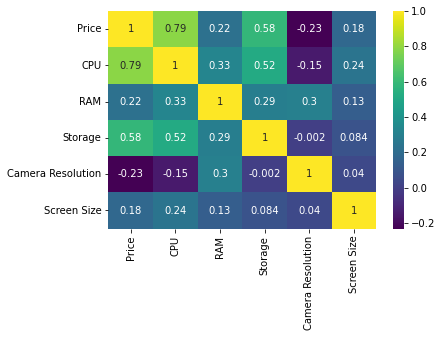

In [85]:
cor = df1.corr()                                  ## correlation martix
sns.heatmap(cor,annot= True , cmap = 'viridis' ) 
plt.show()

In [86]:
df1.dropna(inplace=True)             ## drop the null values that are not filled by now.

### Select Features and Split the Data

I drop 'Model' and 'Color' column because I do not think these are not as effective as other features on price

In [87]:
x= df1.drop(columns = ['Price','Model'])             ## split the features and the label 
x

,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
12,Apple,3.2,6.0,128.0,iOS,7.5,6.25
13,Apple,1.8,2.0,64.0,iOS,12.5,4.00
14,Apple,2.8,4.0,128.0,iOS,12.5,6.00
15,Apple,2.8,4.0,64.0,iOS,12.5,6.00
16,Apple,2.8,4.0,128.0,iOS,12.5,6.00
...,...,...,...,...,...,...,...
1154,Xiaomi,2.3,2.0,32.0,Android,12.5,6.00
1155,Xiaomi,2.3,3.0,64.0,Android,12.5,6.00
1156,Xiaomi,2.3,4.0,128.0,Android,50.0,6.25
1159,Xiaomi,2.3,4.0,128.0,Android,20.0,6.00


In [88]:
le = LabelEncoder()                               ## call label encoder to convert the categorical data into numerical data
x1 = le.fit_transform(x.Brand.values)              ## convert the brand column
x2 = le.fit_transform(x['Operating System'].values)     ## conver the OS column

In [90]:
x.Brand = x1                              ## replace the columns with new format
x['Operating System']  = x2    
x.head(3)

,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
12,0,3.2,6.0,128.0,1,7.5,6.25
13,0,1.8,2.0,64.0,1,12.5,4.00
14,0,2.8,4.0,128.0,1,12.5,6.00


In [91]:
y = df1.Price   ## define target column

In [92]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)  ## split the data into test and train

### XGBoost Regressor

In [93]:
model = xgb.XGBRegressor()       ##call the model

In [94]:
params = {'max_depth' : [15,20,25],              ## define parameter values for tuning.
         'learning_rate':[0.3,0.5,0.7],
         'n_estimators':[300,400,500],
          'min_child_weight':[6,8,10]
         }

In [95]:
grid = GridSearchCV(model,param_grid=params,verbose=2,cv=3)    ## input the components and create a gridsearchcv module.

In [96]:
grid.fit(x_train,y_train);       ## fit the data

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.8s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.7s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.7s
[CV] END learning_rate=0.3, max_depth=15, min_c

[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.2s
[CV] END l

[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=400; total time=   0.4s
[CV] END l

In [97]:
grid.best_estimator_                   ## the gridsearchcv returns the best parameters values.

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [98]:
## pass in the best parameter values.
model_xgb=xgb.XGBRegressor(max_depth=15,min_child_weight=8,n_estimators=500,learning_rate=0.5)    

In [99]:
##  train the data with the tuned parameters.
model_1=model_xgb.fit(x_train,y_train)  

In [100]:
## make predictions

y_pred1=model_1.predict(x_test)

In [101]:
## measure the performance for different metrics.

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))
print('R2 score:', metrics.r2_score(y_pred1,y_test))

Mean Absolute Error: 1163.7010962115833
Mean Squared Error: 4535339.210361445
Root Mean Squared Error: 2129.6335859394794
R2 score: 0.953404811728709


### CatBoost Regressor

In [102]:
## call another model

model1=cb.CatBoostRegressor()

In [103]:
## define parameter values and apply them in a grid module

params1 = {'max_depth':[6,10,15],
          'iterations':[120,150,200],
          'learning_rate':[0.1,0.2,0.3]}

grid1=GridSearchCV(model1,param_grid=params1,verbose=2,cv=3)

In [104]:
grid1.fit(x_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0:	learn: 9165.3873746	total: 149ms	remaining: 17.7s
1:	learn: 8505.5320813	total: 150ms	remaining: 8.84s
2:	learn: 8043.7295726	total: 150ms	remaining: 5.86s
3:	learn: 7502.6391241	total: 151ms	remaining: 4.37s
4:	learn: 7052.1104238	total: 152ms	remaining: 3.49s
5:	learn: 6669.3018374	total: 152ms	remaining: 2.89s
6:	learn: 6221.0531058	total: 154ms	remaining: 2.48s
7:	learn: 5892.2487615	total: 155ms	remaining: 2.17s
8:	learn: 5591.3680781	total: 156ms	remaining: 1.92s
9:	learn: 5300.8812774	total: 157ms	remaining: 1.72s
10:	learn: 5037.3502087	total: 157ms	remaining: 1.56s
11:	learn: 4830.5901384	total: 158ms	remaining: 1.42s
12:	learn: 4622.4315727	total: 158ms	remaining: 1.3s
13:	learn: 4425.6450100	total: 159ms	remaining: 1.2s
14:	learn: 4245.6034080	total: 160ms	remaining: 1.12s
15:	learn: 4108.9463467	total: 160ms	remaining: 1.04s
16:	learn: 3971.4271923	total: 161ms	remaining: 975ms
17:	learn: 3838.4107966	total: 16

88:	learn: 1651.9070540	total: 53.7ms	remaining: 18.7ms
89:	learn: 1646.9387574	total: 54.4ms	remaining: 18.1ms
90:	learn: 1641.0602667	total: 55.2ms	remaining: 17.6ms
91:	learn: 1635.7621227	total: 56.2ms	remaining: 17.1ms
92:	learn: 1631.4752510	total: 56.9ms	remaining: 16.5ms
93:	learn: 1625.3132274	total: 57.6ms	remaining: 15.9ms
94:	learn: 1618.0066092	total: 58.2ms	remaining: 15.3ms
95:	learn: 1614.1629164	total: 58.9ms	remaining: 14.7ms
96:	learn: 1606.0670611	total: 59.7ms	remaining: 14.2ms
97:	learn: 1600.1934883	total: 60.5ms	remaining: 13.6ms
98:	learn: 1595.7583213	total: 61.3ms	remaining: 13ms
99:	learn: 1590.6063186	total: 62.5ms	remaining: 12.5ms
100:	learn: 1585.1758835	total: 63.4ms	remaining: 11.9ms
101:	learn: 1579.1281375	total: 64.7ms	remaining: 11.4ms
102:	learn: 1573.4479425	total: 65.6ms	remaining: 10.8ms
103:	learn: 1568.3098405	total: 66.6ms	remaining: 10.2ms
104:	learn: 1564.7602910	total: 67.5ms	remaining: 9.65ms
105:	learn: 1561.0827547	total: 68.6ms	remain

19:	learn: 3274.3492831	total: 22.3ms	remaining: 111ms
20:	learn: 3157.0388989	total: 24.5ms	remaining: 116ms
21:	learn: 3039.2351549	total: 25.5ms	remaining: 113ms
22:	learn: 2964.8312202	total: 25.9ms	remaining: 109ms
23:	learn: 2886.1839862	total: 26.5ms	remaining: 106ms
24:	learn: 2808.9155374	total: 26.9ms	remaining: 102ms
25:	learn: 2720.4367304	total: 28.1ms	remaining: 102ms
26:	learn: 2676.1831967	total: 28.5ms	remaining: 98.3ms
27:	learn: 2601.2004899	total: 30.3ms	remaining: 99.5ms
28:	learn: 2519.8953795	total: 31.1ms	remaining: 97.6ms
29:	learn: 2435.3347378	total: 32.7ms	remaining: 98ms
30:	learn: 2359.1003829	total: 34.2ms	remaining: 98.2ms
31:	learn: 2315.0794842	total: 37ms	remaining: 102ms
32:	learn: 2238.8337269	total: 38.9ms	remaining: 103ms
33:	learn: 2195.7860431	total: 40.9ms	remaining: 103ms
34:	learn: 2139.7702836	total: 42.5ms	remaining: 103ms
35:	learn: 2107.3003495	total: 45ms	remaining: 105ms
36:	learn: 2069.2847812	total: 47.6ms	remaining: 107ms
37:	learn: 

59:	learn: 1698.9741357	total: 78ms	remaining: 78ms
60:	learn: 1684.0802317	total: 80.3ms	remaining: 77.7ms
61:	learn: 1668.0192833	total: 82.4ms	remaining: 77.1ms
62:	learn: 1651.3658079	total: 84.1ms	remaining: 76.1ms
63:	learn: 1642.3465411	total: 86.4ms	remaining: 75.6ms
64:	learn: 1637.3748738	total: 87.7ms	remaining: 74.2ms
65:	learn: 1620.7709142	total: 89.7ms	remaining: 73.4ms
66:	learn: 1607.9183912	total: 91.4ms	remaining: 72.3ms
67:	learn: 1595.8042663	total: 93.7ms	remaining: 71.6ms
68:	learn: 1584.0214294	total: 95.4ms	remaining: 70.5ms
69:	learn: 1568.2150147	total: 97.1ms	remaining: 69.4ms
70:	learn: 1556.3571213	total: 99ms	remaining: 68.3ms
71:	learn: 1543.1338065	total: 102ms	remaining: 67.8ms
72:	learn: 1530.3427902	total: 103ms	remaining: 66.5ms
73:	learn: 1521.7980986	total: 105ms	remaining: 65.2ms
74:	learn: 1507.6015827	total: 106ms	remaining: 63.9ms
75:	learn: 1495.1991384	total: 108ms	remaining: 62.8ms
76:	learn: 1481.6441651	total: 110ms	remaining: 61.6ms
77:	

89:	learn: 1359.3076327	total: 1.87s	remaining: 624ms
90:	learn: 1352.8820207	total: 1.92s	remaining: 610ms
91:	learn: 1347.7216811	total: 1.96s	remaining: 597ms
92:	learn: 1342.2105404	total: 2s	remaining: 580ms
93:	learn: 1337.4864207	total: 2.04s	remaining: 564ms
94:	learn: 1333.5359399	total: 2.09s	remaining: 550ms
95:	learn: 1329.4286532	total: 2.14s	remaining: 536ms
96:	learn: 1324.5510466	total: 2.19s	remaining: 520ms
97:	learn: 1320.9468704	total: 2.23s	remaining: 501ms
98:	learn: 1317.8665403	total: 2.27s	remaining: 482ms
99:	learn: 1313.8843624	total: 2.28s	remaining: 457ms
100:	learn: 1310.7213183	total: 2.33s	remaining: 438ms
101:	learn: 1307.9274939	total: 2.37s	remaining: 417ms
102:	learn: 1304.0328324	total: 2.41s	remaining: 397ms
103:	learn: 1301.6847378	total: 2.44s	remaining: 376ms
104:	learn: 1297.2245821	total: 2.48s	remaining: 354ms
105:	learn: 1293.8015915	total: 2.53s	remaining: 334ms
106:	learn: 1291.6879442	total: 2.57s	remaining: 313ms
107:	learn: 1289.8153960

[CV] END ....iterations=120, learning_rate=0.1, max_depth=15; total time=   3.1s
0:	learn: 8998.5588832	total: 910us	remaining: 108ms
1:	learn: 8442.8161221	total: 3.14ms	remaining: 185ms
2:	learn: 7907.6873807	total: 7.21ms	remaining: 281ms
3:	learn: 7425.2843985	total: 12ms	remaining: 347ms
4:	learn: 6925.1392950	total: 12.7ms	remaining: 291ms
5:	learn: 6470.6861841	total: 13.6ms	remaining: 259ms
6:	learn: 6084.4357599	total: 14.1ms	remaining: 228ms
7:	learn: 5730.3983031	total: 14.9ms	remaining: 208ms
8:	learn: 5407.7115220	total: 15.3ms	remaining: 189ms
9:	learn: 5092.4959610	total: 15.9ms	remaining: 175ms
10:	learn: 4827.4195089	total: 16.4ms	remaining: 162ms
11:	learn: 4573.9628289	total: 21.7ms	remaining: 195ms
12:	learn: 4376.0201435	total: 23.8ms	remaining: 196ms
13:	learn: 4162.1767358	total: 25.8ms	remaining: 195ms
14:	learn: 3970.2399034	total: 27.4ms	remaining: 192ms
15:	learn: 3817.9834739	total: 27.8ms	remaining: 181ms
16:	learn: 3686.1220669	total: 28.2ms	remaining: 171

25:	learn: 1923.6428252	total: 15.9ms	remaining: 57.7ms
26:	learn: 1899.8678625	total: 16.6ms	remaining: 57.2ms
27:	learn: 1876.7477298	total: 17.2ms	remaining: 56.4ms
28:	learn: 1846.0094571	total: 17.9ms	remaining: 56.2ms
29:	learn: 1822.0400499	total: 18.7ms	remaining: 56.1ms
30:	learn: 1779.1413610	total: 19.5ms	remaining: 56.1ms
31:	learn: 1753.0423661	total: 20.3ms	remaining: 55.9ms
32:	learn: 1735.9503989	total: 21.2ms	remaining: 55.8ms
33:	learn: 1723.8228565	total: 21.8ms	remaining: 55.2ms
34:	learn: 1692.4592737	total: 22.4ms	remaining: 54.5ms
35:	learn: 1678.2944914	total: 22.9ms	remaining: 53.5ms
36:	learn: 1646.0461187	total: 23.6ms	remaining: 52.9ms
37:	learn: 1628.2447496	total: 24.2ms	remaining: 52.2ms
38:	learn: 1600.8969774	total: 24.9ms	remaining: 51.7ms
39:	learn: 1587.6634732	total: 25.6ms	remaining: 51.3ms
40:	learn: 1566.1758098	total: 26.4ms	remaining: 50.8ms
41:	learn: 1550.0731669	total: 26.9ms	remaining: 49.9ms
42:	learn: 1528.3423754	total: 27.7ms	remaining:

92:	learn: 1329.7870635	total: 58.4ms	remaining: 16.9ms
93:	learn: 1327.7158639	total: 59.3ms	remaining: 16.4ms
94:	learn: 1324.2615970	total: 60.1ms	remaining: 15.8ms
95:	learn: 1318.9349256	total: 60.8ms	remaining: 15.2ms
96:	learn: 1316.8454200	total: 61.4ms	remaining: 14.6ms
97:	learn: 1315.2392713	total: 61.9ms	remaining: 13.9ms
98:	learn: 1311.8182619	total: 62.5ms	remaining: 13.2ms
99:	learn: 1310.4733994	total: 63ms	remaining: 12.6ms
100:	learn: 1309.2014330	total: 63.5ms	remaining: 11.9ms
101:	learn: 1305.7867705	total: 64.1ms	remaining: 11.3ms
102:	learn: 1304.3569272	total: 64.6ms	remaining: 10.7ms
103:	learn: 1300.4171142	total: 65.2ms	remaining: 10ms
104:	learn: 1299.3137738	total: 65.8ms	remaining: 9.4ms
105:	learn: 1297.0865527	total: 66.5ms	remaining: 8.79ms
106:	learn: 1295.6424757	total: 67.3ms	remaining: 8.18ms
107:	learn: 1292.4548854	total: 68.6ms	remaining: 7.62ms
108:	learn: 1289.4776904	total: 69.4ms	remaining: 7ms
109:	learn: 1287.9658893	total: 70.2ms	remainin

13:	learn: 2511.2882693	total: 18.5ms	remaining: 140ms
14:	learn: 2326.8730272	total: 20.8ms	remaining: 145ms
15:	learn: 2245.0010909	total: 21.6ms	remaining: 140ms
16:	learn: 2172.8686845	total: 24.8ms	remaining: 150ms
17:	learn: 2081.9428243	total: 27.6ms	remaining: 156ms
18:	learn: 1990.5457452	total: 29.4ms	remaining: 156ms
19:	learn: 1940.3017348	total: 31.7ms	remaining: 158ms
20:	learn: 1917.0579115	total: 32.3ms	remaining: 152ms
21:	learn: 1848.9222773	total: 34.3ms	remaining: 153ms
22:	learn: 1786.2170756	total: 35.9ms	remaining: 151ms
23:	learn: 1731.7602276	total: 38ms	remaining: 152ms
24:	learn: 1673.2229633	total: 39.8ms	remaining: 151ms
25:	learn: 1643.9046387	total: 41.4ms	remaining: 150ms
26:	learn: 1628.1524861	total: 41.9ms	remaining: 144ms
27:	learn: 1616.0137964	total: 42.2ms	remaining: 139ms
28:	learn: 1561.7962619	total: 43.7ms	remaining: 137ms
29:	learn: 1556.5803923	total: 44.2ms	remaining: 133ms
30:	learn: 1549.0640696	total: 44.6ms	remaining: 128ms
31:	learn: 1

44:	learn: 1396.7832281	total: 74.2ms	remaining: 124ms
45:	learn: 1383.5330568	total: 76ms	remaining: 122ms
46:	learn: 1373.7064340	total: 78.7ms	remaining: 122ms
47:	learn: 1359.4866827	total: 81.1ms	remaining: 122ms
48:	learn: 1352.6027325	total: 83.8ms	remaining: 121ms
49:	learn: 1345.4592234	total: 87.8ms	remaining: 123ms
50:	learn: 1332.3489668	total: 89.7ms	remaining: 121ms
51:	learn: 1324.9540557	total: 92ms	remaining: 120ms
52:	learn: 1316.4942316	total: 94.9ms	remaining: 120ms
53:	learn: 1308.4726737	total: 96.9ms	remaining: 118ms
54:	learn: 1304.0937973	total: 100ms	remaining: 118ms
55:	learn: 1300.3045160	total: 102ms	remaining: 117ms
56:	learn: 1297.0386381	total: 104ms	remaining: 115ms
57:	learn: 1293.6782906	total: 106ms	remaining: 114ms
58:	learn: 1285.6479665	total: 108ms	remaining: 112ms
59:	learn: 1284.1392176	total: 109ms	remaining: 109ms
60:	learn: 1276.7623796	total: 111ms	remaining: 107ms
61:	learn: 1271.7276261	total: 114ms	remaining: 106ms
62:	learn: 1265.038671

75:	learn: 1233.8237940	total: 2.12s	remaining: 1.23s
76:	learn: 1233.0215226	total: 2.19s	remaining: 1.22s
77:	learn: 1232.0597765	total: 2.25s	remaining: 1.21s
78:	learn: 1231.4428006	total: 2.26s	remaining: 1.17s
79:	learn: 1230.7315052	total: 2.31s	remaining: 1.15s
80:	learn: 1230.0514440	total: 2.36s	remaining: 1.14s
81:	learn: 1229.3278188	total: 2.4s	remaining: 1.11s
82:	learn: 1228.7490765	total: 2.45s	remaining: 1.09s
83:	learn: 1228.1707667	total: 2.5s	remaining: 1.07s
84:	learn: 1227.5843936	total: 2.54s	remaining: 1.04s
85:	learn: 1227.1226243	total: 2.58s	remaining: 1.02s
86:	learn: 1226.6327067	total: 2.63s	remaining: 998ms
87:	learn: 1226.2035449	total: 2.68s	remaining: 974ms
88:	learn: 1225.9099807	total: 2.72s	remaining: 948ms
89:	learn: 1225.6412144	total: 2.77s	remaining: 924ms
90:	learn: 1225.2175612	total: 2.85s	remaining: 907ms
91:	learn: 1224.8677390	total: 2.89s	remaining: 881ms
92:	learn: 1224.7806487	total: 2.9s	remaining: 842ms
93:	learn: 1224.4102817	total: 

108:	learn: 1034.3495999	total: 3.39s	remaining: 342ms
109:	learn: 1034.2726177	total: 3.44s	remaining: 313ms
110:	learn: 1034.2070409	total: 3.49s	remaining: 283ms
111:	learn: 1034.1692293	total: 3.49s	remaining: 249ms
112:	learn: 1034.0952495	total: 3.53s	remaining: 219ms
113:	learn: 1034.0512180	total: 3.57s	remaining: 188ms
114:	learn: 1034.0217638	total: 3.6s	remaining: 156ms
115:	learn: 1033.9797521	total: 3.63s	remaining: 125ms
116:	learn: 1033.9123495	total: 3.67s	remaining: 94.1ms
117:	learn: 1033.8759425	total: 3.71s	remaining: 62.9ms
118:	learn: 1033.8308972	total: 3.75s	remaining: 31.5ms
119:	learn: 1033.7912229	total: 3.79s	remaining: 0us
[CV] END ....iterations=120, learning_rate=0.2, max_depth=15; total time=   4.4s
0:	learn: 8349.3330920	total: 1.05ms	remaining: 126ms
1:	learn: 7340.7453807	total: 2.81ms	remaining: 166ms
2:	learn: 6541.8158289	total: 20.4ms	remaining: 797ms
3:	learn: 5879.2032911	total: 21.3ms	remaining: 618ms
4:	learn: 5197.1932162	total: 23.3ms	remain

39:	learn: 1366.8304928	total: 23.9ms	remaining: 47.8ms
40:	learn: 1363.1836427	total: 24.6ms	remaining: 47.4ms
41:	learn: 1355.1290320	total: 25.4ms	remaining: 47.1ms
42:	learn: 1343.6726978	total: 27ms	remaining: 48.3ms
43:	learn: 1326.6660045	total: 28.2ms	remaining: 48.6ms
44:	learn: 1317.9664135	total: 29.1ms	remaining: 48.5ms
45:	learn: 1310.9256522	total: 30.3ms	remaining: 48.7ms
46:	learn: 1296.9615842	total: 31.1ms	remaining: 48.3ms
47:	learn: 1290.7184118	total: 31.6ms	remaining: 47.4ms
48:	learn: 1277.7119821	total: 32.2ms	remaining: 46.7ms
49:	learn: 1259.8830643	total: 33ms	remaining: 46.1ms
50:	learn: 1245.4445056	total: 33.8ms	remaining: 45.8ms
51:	learn: 1237.3672504	total: 34.7ms	remaining: 45.4ms
52:	learn: 1226.6376106	total: 35.3ms	remaining: 44.6ms
53:	learn: 1221.1381516	total: 36.1ms	remaining: 44.1ms
54:	learn: 1217.1523033	total: 36.7ms	remaining: 43.4ms
55:	learn: 1214.8512064	total: 37.4ms	remaining: 42.7ms
56:	learn: 1205.6430166	total: 38.1ms	remaining: 42.

44:	learn: 1298.4405293	total: 71.6ms	remaining: 119ms
45:	learn: 1292.3315660	total: 73.8ms	remaining: 119ms
46:	learn: 1287.8539999	total: 75.4ms	remaining: 117ms
47:	learn: 1284.1455824	total: 76.9ms	remaining: 115ms
48:	learn: 1279.9860503	total: 78.8ms	remaining: 114ms
49:	learn: 1277.3617384	total: 81.2ms	remaining: 114ms
50:	learn: 1273.6869147	total: 83.2ms	remaining: 113ms
51:	learn: 1271.0545091	total: 86.6ms	remaining: 113ms
52:	learn: 1268.5382343	total: 88.8ms	remaining: 112ms
53:	learn: 1265.6099934	total: 90.5ms	remaining: 111ms
54:	learn: 1262.4262780	total: 93.3ms	remaining: 110ms
55:	learn: 1261.4497272	total: 95.4ms	remaining: 109ms
56:	learn: 1259.3438873	total: 96.9ms	remaining: 107ms
57:	learn: 1257.7105668	total: 98.8ms	remaining: 106ms
58:	learn: 1255.7031553	total: 101ms	remaining: 104ms
59:	learn: 1253.9074072	total: 102ms	remaining: 102ms
60:	learn: 1252.4882190	total: 104ms	remaining: 101ms
61:	learn: 1251.3943662	total: 106ms	remaining: 98.9ms
62:	learn: 12

93:	learn: 1037.6161520	total: 163ms	remaining: 45ms
94:	learn: 1037.6075954	total: 164ms	remaining: 43.1ms
95:	learn: 1037.4922460	total: 165ms	remaining: 41.4ms
96:	learn: 1037.2418260	total: 168ms	remaining: 39.8ms
97:	learn: 1037.0802562	total: 169ms	remaining: 38ms
98:	learn: 1036.9212616	total: 173ms	remaining: 36.8ms
99:	learn: 1036.6829818	total: 175ms	remaining: 35ms
100:	learn: 1036.5700969	total: 177ms	remaining: 33.3ms
101:	learn: 1036.3988464	total: 180ms	remaining: 31.7ms
102:	learn: 1036.3349308	total: 181ms	remaining: 29.9ms
103:	learn: 1036.2125034	total: 183ms	remaining: 28.2ms
104:	learn: 1036.0376589	total: 187ms	remaining: 26.7ms
105:	learn: 1036.0037451	total: 189ms	remaining: 25ms
106:	learn: 1035.9038439	total: 191ms	remaining: 23.2ms
107:	learn: 1035.7626305	total: 194ms	remaining: 21.5ms
108:	learn: 1035.6781202	total: 195ms	remaining: 19.7ms
109:	learn: 1035.6195782	total: 197ms	remaining: 17.9ms
110:	learn: 1035.4577522	total: 199ms	remaining: 16.1ms
111:	le

23:	learn: 1604.4700635	total: 138ms	remaining: 553ms
24:	learn: 1542.6627959	total: 177ms	remaining: 674ms
25:	learn: 1503.4631418	total: 224ms	remaining: 810ms
26:	learn: 1459.7213356	total: 279ms	remaining: 959ms
27:	learn: 1428.9575213	total: 335ms	remaining: 1.1s
28:	learn: 1400.3252280	total: 380ms	remaining: 1.19s
29:	learn: 1377.1700987	total: 417ms	remaining: 1.25s
30:	learn: 1356.0766846	total: 453ms	remaining: 1.3s
31:	learn: 1343.0211298	total: 497ms	remaining: 1.37s
32:	learn: 1327.0459154	total: 550ms	remaining: 1.45s
33:	learn: 1314.6512128	total: 594ms	remaining: 1.5s
34:	learn: 1303.6782918	total: 635ms	remaining: 1.54s
35:	learn: 1295.1678000	total: 673ms	remaining: 1.57s
36:	learn: 1286.0462177	total: 713ms	remaining: 1.6s
37:	learn: 1278.2092210	total: 750ms	remaining: 1.62s
38:	learn: 1272.0109300	total: 793ms	remaining: 1.65s
39:	learn: 1266.1295179	total: 831ms	remaining: 1.66s
40:	learn: 1260.9449178	total: 883ms	remaining: 1.7s
41:	learn: 1256.0870322	total: 93

58:	learn: 1036.6256930	total: 1.72s	remaining: 1.78s
59:	learn: 1036.3984632	total: 1.76s	remaining: 1.76s
60:	learn: 1036.0060596	total: 1.8s	remaining: 1.74s
61:	learn: 1035.7957514	total: 1.84s	remaining: 1.72s
62:	learn: 1035.5102840	total: 1.88s	remaining: 1.7s
63:	learn: 1035.3280927	total: 1.88s	remaining: 1.65s
64:	learn: 1035.1685333	total: 1.92s	remaining: 1.63s
65:	learn: 1034.9642872	total: 1.97s	remaining: 1.61s
66:	learn: 1034.8130243	total: 2.01s	remaining: 1.59s
67:	learn: 1034.6943197	total: 2.03s	remaining: 1.55s
68:	learn: 1034.5512388	total: 2.07s	remaining: 1.53s
69:	learn: 1034.4399378	total: 2.11s	remaining: 1.5s
70:	learn: 1034.3082885	total: 2.15s	remaining: 1.48s
71:	learn: 1034.2133033	total: 2.19s	remaining: 1.46s
72:	learn: 1034.1405398	total: 2.23s	remaining: 1.44s
73:	learn: 1034.0349192	total: 2.27s	remaining: 1.41s
74:	learn: 1033.9328831	total: 2.31s	remaining: 1.39s
75:	learn: 1033.8753877	total: 2.35s	remaining: 1.36s
76:	learn: 1033.8047820	total: 

93:	learn: 1143.6837909	total: 3.08s	remaining: 853ms
94:	learn: 1143.6623836	total: 3.13s	remaining: 823ms
95:	learn: 1143.6371292	total: 3.16s	remaining: 791ms
96:	learn: 1143.6113626	total: 3.2s	remaining: 760ms
97:	learn: 1143.5902131	total: 3.24s	remaining: 728ms
98:	learn: 1143.5693594	total: 3.28s	remaining: 696ms
99:	learn: 1143.5545798	total: 3.33s	remaining: 667ms
100:	learn: 1143.5377393	total: 3.38s	remaining: 636ms
101:	learn: 1143.5231265	total: 3.43s	remaining: 605ms
102:	learn: 1143.4992172	total: 3.48s	remaining: 574ms
103:	learn: 1143.4833543	total: 3.53s	remaining: 543ms
104:	learn: 1143.4720121	total: 3.57s	remaining: 510ms
105:	learn: 1143.4643208	total: 3.62s	remaining: 478ms
106:	learn: 1143.4585143	total: 3.66s	remaining: 444ms
107:	learn: 1143.4521073	total: 3.68s	remaining: 408ms
108:	learn: 1143.4400895	total: 3.71s	remaining: 375ms
109:	learn: 1143.4341058	total: 3.75s	remaining: 341ms
110:	learn: 1143.4327175	total: 3.75s	remaining: 305ms
111:	learn: 1143.4

1:	learn: 8768.9713515	total: 1.4ms	remaining: 104ms
2:	learn: 8190.6259899	total: 2.13ms	remaining: 104ms
3:	learn: 7704.9372314	total: 2.8ms	remaining: 102ms
4:	learn: 7188.5080640	total: 3.77ms	remaining: 109ms
5:	learn: 6768.5814205	total: 4.72ms	remaining: 113ms
6:	learn: 6338.2170654	total: 5.44ms	remaining: 111ms
7:	learn: 5939.7860498	total: 6.16ms	remaining: 109ms
8:	learn: 5588.6067945	total: 6.91ms	remaining: 108ms
9:	learn: 5276.4810353	total: 7.51ms	remaining: 105ms
10:	learn: 4988.5377213	total: 8.07ms	remaining: 102ms
11:	learn: 4751.6321753	total: 8.48ms	remaining: 97.5ms
12:	learn: 4532.5060919	total: 8.88ms	remaining: 93.5ms
13:	learn: 4320.9951763	total: 9.74ms	remaining: 94.6ms
14:	learn: 4147.8589348	total: 10.7ms	remaining: 96.7ms
15:	learn: 3991.5477203	total: 11.5ms	remaining: 96.6ms
16:	learn: 3837.3598542	total: 13.4ms	remaining: 105ms
17:	learn: 3706.7179396	total: 14.1ms	remaining: 103ms
18:	learn: 3561.6874477	total: 15ms	remaining: 103ms
19:	learn: 3447.87

3:	learn: 7289.2098436	total: 3.63ms	remaining: 132ms
4:	learn: 6802.1395662	total: 4.66ms	remaining: 135ms
5:	learn: 6416.2458801	total: 5.54ms	remaining: 133ms
6:	learn: 6038.2298765	total: 6.66ms	remaining: 136ms
7:	learn: 5661.9374132	total: 7.52ms	remaining: 134ms
8:	learn: 5355.3639593	total: 8.36ms	remaining: 131ms
9:	learn: 5076.4644124	total: 9.18ms	remaining: 129ms
10:	learn: 4875.8543637	total: 9.81ms	remaining: 124ms
11:	learn: 4655.4131425	total: 10.6ms	remaining: 122ms
12:	learn: 4459.6983856	total: 11.7ms	remaining: 123ms
13:	learn: 4280.5960261	total: 13.1ms	remaining: 127ms
14:	learn: 4133.3903987	total: 13.9ms	remaining: 125ms
15:	learn: 3958.9208770	total: 14.9ms	remaining: 125ms
16:	learn: 3805.4332001	total: 15.8ms	remaining: 124ms
17:	learn: 3679.1754770	total: 17ms	remaining: 125ms
18:	learn: 3564.4385655	total: 17.9ms	remaining: 123ms
19:	learn: 3455.9781544	total: 18.8ms	remaining: 122ms
20:	learn: 3348.7600716	total: 20.1ms	remaining: 124ms
21:	learn: 3260.162

1:	learn: 8587.8835882	total: 9.5ms	remaining: 703ms
2:	learn: 8010.5862273	total: 10.6ms	remaining: 521ms
3:	learn: 7480.1163365	total: 11.3ms	remaining: 413ms
4:	learn: 7006.4556673	total: 13.8ms	remaining: 400ms
5:	learn: 6541.3915787	total: 15.2ms	remaining: 366ms
6:	learn: 6178.2603811	total: 16.1ms	remaining: 329ms
7:	learn: 5829.2750907	total: 17.2ms	remaining: 305ms
8:	learn: 5499.5479188	total: 18ms	remaining: 282ms
9:	learn: 5167.4294793	total: 19ms	remaining: 267ms
10:	learn: 4869.8125926	total: 23.6ms	remaining: 298ms
11:	learn: 4635.8554416	total: 24.8ms	remaining: 285ms
12:	learn: 4415.4774047	total: 25.8ms	remaining: 272ms
13:	learn: 4225.6517151	total: 29.3ms	remaining: 284ms
14:	learn: 4029.6083374	total: 31.5ms	remaining: 284ms
15:	learn: 3866.5348566	total: 32.8ms	remaining: 275ms
16:	learn: 3717.6343476	total: 34.2ms	remaining: 268ms
17:	learn: 3604.2820690	total: 35ms	remaining: 257ms
18:	learn: 3472.8263994	total: 36.6ms	remaining: 253ms
19:	learn: 3338.1136191	to

0:	learn: 9442.3152988	total: 1.57ms	remaining: 234ms
1:	learn: 8835.4434849	total: 5.01ms	remaining: 371ms
2:	learn: 8256.7738474	total: 6.66ms	remaining: 327ms
3:	learn: 7707.8418357	total: 7.36ms	remaining: 269ms
4:	learn: 7172.7840377	total: 8.36ms	remaining: 242ms
5:	learn: 6673.9045669	total: 9.43ms	remaining: 226ms
6:	learn: 6270.3334735	total: 11.5ms	remaining: 234ms
7:	learn: 5890.9179672	total: 14ms	remaining: 248ms
8:	learn: 5565.2126030	total: 16.3ms	remaining: 256ms
9:	learn: 5265.7954514	total: 18.2ms	remaining: 254ms
10:	learn: 5000.1731581	total: 18.8ms	remaining: 237ms
11:	learn: 4782.5859294	total: 19.2ms	remaining: 221ms
12:	learn: 4544.4633080	total: 20ms	remaining: 211ms
13:	learn: 4297.4004167	total: 21.6ms	remaining: 210ms
14:	learn: 4051.4218554	total: 22.6ms	remaining: 204ms
15:	learn: 3868.1718739	total: 23.5ms	remaining: 197ms
16:	learn: 3741.2800001	total: 24ms	remaining: 188ms
17:	learn: 3576.8568518	total: 24.9ms	remaining: 183ms
18:	learn: 3404.4538988	to

1:	learn: 8442.8161221	total: 5.14ms	remaining: 381ms
2:	learn: 7907.6873807	total: 8.43ms	remaining: 413ms
3:	learn: 7380.3853048	total: 9.96ms	remaining: 363ms
4:	learn: 6875.4949769	total: 11.7ms	remaining: 339ms
5:	learn: 6447.3262567	total: 13.3ms	remaining: 320ms
6:	learn: 6046.7285565	total: 16.9ms	remaining: 346ms
7:	learn: 5712.3214875	total: 17.4ms	remaining: 309ms
8:	learn: 5408.4892557	total: 18.9ms	remaining: 295ms
9:	learn: 5100.5109054	total: 20.6ms	remaining: 288ms
10:	learn: 4829.2782374	total: 21.4ms	remaining: 270ms
11:	learn: 4614.7711543	total: 22.7ms	remaining: 261ms
12:	learn: 4390.1648145	total: 25.5ms	remaining: 269ms
13:	learn: 4232.0349899	total: 26.6ms	remaining: 259ms
14:	learn: 4022.9453183	total: 29ms	remaining: 261ms
15:	learn: 3916.2573759	total: 29.5ms	remaining: 247ms
16:	learn: 3742.9963138	total: 30.6ms	remaining: 240ms
17:	learn: 3618.2363568	total: 31.3ms	remaining: 230ms
18:	learn: 3471.4893528	total: 33.6ms	remaining: 232ms
19:	learn: 3335.75534

0:	learn: 9174.6114753	total: 1.42ms	remaining: 212ms
1:	learn: 8587.8835882	total: 5.7ms	remaining: 422ms
2:	learn: 8010.5862273	total: 6.77ms	remaining: 332ms
3:	learn: 7480.1163365	total: 7.49ms	remaining: 273ms
4:	learn: 7006.4556673	total: 8.68ms	remaining: 252ms
5:	learn: 6541.3915787	total: 9.53ms	remaining: 229ms
6:	learn: 6178.2603811	total: 10.1ms	remaining: 207ms
7:	learn: 5829.2750907	total: 10.8ms	remaining: 192ms
8:	learn: 5499.5479188	total: 11.6ms	remaining: 182ms
9:	learn: 5167.4294793	total: 13.4ms	remaining: 188ms
10:	learn: 4876.3179449	total: 20.8ms	remaining: 262ms
11:	learn: 4633.1535945	total: 21.6ms	remaining: 248ms
12:	learn: 4416.0101325	total: 22.1ms	remaining: 233ms
13:	learn: 4227.5640472	total: 25ms	remaining: 243ms
14:	learn: 4029.7915662	total: 27ms	remaining: 243ms
15:	learn: 3866.5776247	total: 45.7ms	remaining: 383ms
16:	learn: 3703.3997736	total: 57.7ms	remaining: 452ms
17:	learn: 3574.9903871	total: 58.5ms	remaining: 429ms
18:	learn: 3427.2393123	t

41:	learn: 1818.7344865	total: 173ms	remaining: 445ms
42:	learn: 1798.4112132	total: 177ms	remaining: 441ms
43:	learn: 1778.0706151	total: 178ms	remaining: 429ms
44:	learn: 1737.2075295	total: 222ms	remaining: 519ms
45:	learn: 1716.7521469	total: 224ms	remaining: 507ms
46:	learn: 1685.3368654	total: 234ms	remaining: 512ms
47:	learn: 1653.4356516	total: 258ms	remaining: 548ms
48:	learn: 1634.1197505	total: 260ms	remaining: 535ms
49:	learn: 1625.4203938	total: 260ms	remaining: 521ms
50:	learn: 1614.0322917	total: 261ms	remaining: 506ms
51:	learn: 1605.5048928	total: 262ms	remaining: 493ms
52:	learn: 1579.5459458	total: 263ms	remaining: 481ms
53:	learn: 1552.7512666	total: 302ms	remaining: 538ms
54:	learn: 1523.7993382	total: 312ms	remaining: 538ms
55:	learn: 1492.5523467	total: 367ms	remaining: 615ms
56:	learn: 1476.4461256	total: 389ms	remaining: 634ms
57:	learn: 1471.8557765	total: 389ms	remaining: 618ms
58:	learn: 1446.1206081	total: 432ms	remaining: 667ms
59:	learn: 1420.0208862	tota

54:	learn: 1704.2467064	total: 405ms	remaining: 699ms
55:	learn: 1690.9397073	total: 407ms	remaining: 683ms
56:	learn: 1680.4901777	total: 409ms	remaining: 668ms
57:	learn: 1665.1161066	total: 415ms	remaining: 658ms
58:	learn: 1643.5048618	total: 421ms	remaining: 649ms
59:	learn: 1618.7974344	total: 473ms	remaining: 709ms
60:	learn: 1594.6473432	total: 509ms	remaining: 743ms
61:	learn: 1578.8170295	total: 514ms	remaining: 730ms
62:	learn: 1573.5382161	total: 515ms	remaining: 712ms
63:	learn: 1552.9705680	total: 551ms	remaining: 741ms
64:	learn: 1536.5239631	total: 588ms	remaining: 768ms
65:	learn: 1524.8443416	total: 592ms	remaining: 754ms
66:	learn: 1512.0985807	total: 595ms	remaining: 738ms
67:	learn: 1494.8701451	total: 632ms	remaining: 762ms
68:	learn: 1480.7030820	total: 670ms	remaining: 786ms
69:	learn: 1469.3076072	total: 675ms	remaining: 771ms
70:	learn: 1454.6393297	total: 713ms	remaining: 794ms
71:	learn: 1443.2068676	total: 734ms	remaining: 795ms
72:	learn: 1432.5102276	tota

134:	learn: 1330.2979931	total: 102ms	remaining: 11.3ms
135:	learn: 1329.1697464	total: 103ms	remaining: 10.6ms
136:	learn: 1328.8172016	total: 104ms	remaining: 9.91ms
137:	learn: 1325.8939863	total: 105ms	remaining: 9.17ms
138:	learn: 1325.0565602	total: 106ms	remaining: 8.42ms
139:	learn: 1322.4771551	total: 108ms	remaining: 7.69ms
140:	learn: 1321.4961226	total: 109ms	remaining: 6.94ms
141:	learn: 1319.7050176	total: 110ms	remaining: 6.17ms
142:	learn: 1319.1023993	total: 111ms	remaining: 5.41ms
143:	learn: 1317.7674467	total: 112ms	remaining: 4.65ms
144:	learn: 1316.9990386	total: 112ms	remaining: 3.87ms
145:	learn: 1315.9683295	total: 113ms	remaining: 3.1ms
146:	learn: 1313.8551920	total: 114ms	remaining: 2.33ms
147:	learn: 1312.7234186	total: 115ms	remaining: 1.56ms
148:	learn: 1312.0358753	total: 116ms	remaining: 779us
149:	learn: 1311.2404617	total: 117ms	remaining: 0us
[CV] END .....iterations=150, learning_rate=0.2, max_depth=6; total time=   0.1s
0:	learn: 8674.7149101	total

121:	learn: 1264.8084531	total: 96.8ms	remaining: 22.2ms
122:	learn: 1263.9417297	total: 97.6ms	remaining: 21.4ms
123:	learn: 1262.4738805	total: 98.6ms	remaining: 20.7ms
124:	learn: 1259.9309919	total: 99.3ms	remaining: 19.9ms
125:	learn: 1257.3770123	total: 101ms	remaining: 19.2ms
126:	learn: 1255.6783739	total: 102ms	remaining: 18.4ms
127:	learn: 1254.8304715	total: 102ms	remaining: 17.6ms
128:	learn: 1253.9798793	total: 103ms	remaining: 16.8ms
129:	learn: 1253.2628579	total: 104ms	remaining: 16ms
130:	learn: 1252.4166650	total: 105ms	remaining: 15.2ms
131:	learn: 1251.7183907	total: 106ms	remaining: 14.4ms
132:	learn: 1251.3938180	total: 108ms	remaining: 13.8ms
133:	learn: 1250.0509387	total: 108ms	remaining: 12.9ms
134:	learn: 1249.0623923	total: 110ms	remaining: 12.2ms
135:	learn: 1248.9424370	total: 110ms	remaining: 11.3ms
136:	learn: 1248.3652497	total: 111ms	remaining: 10.5ms
137:	learn: 1247.3577707	total: 111ms	remaining: 9.69ms
138:	learn: 1246.8908023	total: 112ms	remainin

133:	learn: 1228.9257838	total: 274ms	remaining: 32.8ms
134:	learn: 1228.6606513	total: 276ms	remaining: 30.7ms
135:	learn: 1228.4328653	total: 279ms	remaining: 28.7ms
136:	learn: 1228.2018532	total: 281ms	remaining: 26.7ms
137:	learn: 1227.9407906	total: 283ms	remaining: 24.6ms
138:	learn: 1227.6545042	total: 286ms	remaining: 22.6ms
139:	learn: 1227.4650307	total: 288ms	remaining: 20.6ms
140:	learn: 1227.3335421	total: 290ms	remaining: 18.5ms
141:	learn: 1227.0341925	total: 292ms	remaining: 16.4ms
142:	learn: 1226.7147594	total: 295ms	remaining: 14.4ms
143:	learn: 1226.5779238	total: 298ms	remaining: 12.4ms
144:	learn: 1226.4533188	total: 300ms	remaining: 10.3ms
145:	learn: 1226.3239333	total: 301ms	remaining: 8.25ms
146:	learn: 1226.0979482	total: 303ms	remaining: 6.18ms
147:	learn: 1225.9441343	total: 305ms	remaining: 4.12ms
148:	learn: 1225.8524741	total: 307ms	remaining: 2.06ms
149:	learn: 1225.7334139	total: 310ms	remaining: 0us
[CV] END ....iterations=150, learning_rate=0.2, max

0:	learn: 8349.3330920	total: 2.39ms	remaining: 356ms
1:	learn: 7340.7453807	total: 4.53ms	remaining: 335ms
2:	learn: 6469.4850216	total: 6.92ms	remaining: 339ms
3:	learn: 5690.3861444	total: 7.9ms	remaining: 288ms
4:	learn: 5011.8436416	total: 9.24ms	remaining: 268ms
5:	learn: 4497.9699960	total: 11.5ms	remaining: 276ms
6:	learn: 4073.7008652	total: 12.6ms	remaining: 258ms
7:	learn: 3718.5850787	total: 14.6ms	remaining: 259ms
8:	learn: 3498.1296761	total: 15.5ms	remaining: 243ms
9:	learn: 3268.1961929	total: 16.3ms	remaining: 229ms
10:	learn: 3080.9044524	total: 17.2ms	remaining: 218ms
11:	learn: 2911.6893088	total: 18.4ms	remaining: 212ms
12:	learn: 2763.8387444	total: 21.3ms	remaining: 224ms
13:	learn: 2681.0560264	total: 22.1ms	remaining: 215ms
14:	learn: 2539.2752783	total: 24.1ms	remaining: 217ms
15:	learn: 2418.4073859	total: 26.6ms	remaining: 223ms
16:	learn: 2301.3610613	total: 29ms	remaining: 227ms
17:	learn: 2265.2955123	total: 29.7ms	remaining: 218ms
18:	learn: 2173.5271709

17:	learn: 2282.4932803	total: 80.5ms	remaining: 590ms
18:	learn: 2211.0358145	total: 82.8ms	remaining: 571ms
19:	learn: 2186.3535485	total: 83.7ms	remaining: 544ms
20:	learn: 2127.0982852	total: 85.1ms	remaining: 523ms
21:	learn: 2098.5419560	total: 86.2ms	remaining: 502ms
22:	learn: 2023.5684908	total: 129ms	remaining: 715ms
23:	learn: 1984.1059233	total: 131ms	remaining: 690ms
24:	learn: 1930.0379469	total: 139ms	remaining: 694ms
25:	learn: 1882.1351828	total: 153ms	remaining: 728ms
26:	learn: 1857.2397593	total: 154ms	remaining: 703ms
27:	learn: 1838.1258827	total: 159ms	remaining: 691ms
28:	learn: 1778.2522173	total: 166ms	remaining: 691ms
29:	learn: 1757.2853993	total: 167ms	remaining: 668ms
30:	learn: 1707.9269852	total: 209ms	remaining: 803ms
31:	learn: 1690.5935408	total: 244ms	remaining: 899ms
32:	learn: 1658.5479098	total: 268ms	remaining: 950ms
33:	learn: 1618.2417049	total: 282ms	remaining: 962ms
34:	learn: 1594.1141980	total: 321ms	remaining: 1.05s
35:	learn: 1586.7813408

35:	learn: 1339.3325931	total: 205ms	remaining: 648ms
36:	learn: 1302.1979607	total: 240ms	remaining: 733ms
37:	learn: 1300.1579761	total: 241ms	remaining: 710ms
38:	learn: 1266.6840278	total: 276ms	remaining: 786ms
39:	learn: 1236.7816865	total: 311ms	remaining: 856ms
40:	learn: 1210.6517455	total: 347ms	remaining: 922ms
41:	learn: 1188.9789276	total: 383ms	remaining: 986ms
42:	learn: 1170.7503357	total: 426ms	remaining: 1.06s
43:	learn: 1154.8252828	total: 468ms	remaining: 1.13s
44:	learn: 1140.6311964	total: 510ms	remaining: 1.19s
45:	learn: 1128.1710002	total: 562ms	remaining: 1.27s
46:	learn: 1117.8850077	total: 614ms	remaining: 1.34s
47:	learn: 1108.6032337	total: 660ms	remaining: 1.4s
48:	learn: 1100.8505186	total: 707ms	remaining: 1.46s
49:	learn: 1095.0653635	total: 750ms	remaining: 1.5s
50:	learn: 1089.2346944	total: 788ms	remaining: 1.53s
51:	learn: 1084.0703799	total: 824ms	remaining: 1.55s
52:	learn: 1079.1365887	total: 860ms	remaining: 1.57s
53:	learn: 1074.4294732	total:

37:	learn: 1418.0470845	total: 540ms	remaining: 1.59s
38:	learn: 1409.4596277	total: 542ms	remaining: 1.54s
39:	learn: 1384.4328996	total: 708ms	remaining: 1.95s
40:	learn: 1360.7390642	total: 760ms	remaining: 2.02s
41:	learn: 1341.5094589	total: 814ms	remaining: 2.09s
42:	learn: 1325.6487666	total: 882ms	remaining: 2.19s
43:	learn: 1313.6148614	total: 932ms	remaining: 2.25s
44:	learn: 1303.7689984	total: 980ms	remaining: 2.29s
45:	learn: 1292.2991757	total: 1.02s	remaining: 2.32s
46:	learn: 1283.5631972	total: 1.08s	remaining: 2.36s
47:	learn: 1272.6384791	total: 1.12s	remaining: 2.38s
48:	learn: 1263.4322315	total: 1.17s	remaining: 2.41s
49:	learn: 1255.5278045	total: 1.22s	remaining: 2.43s
50:	learn: 1247.5093190	total: 1.26s	remaining: 2.45s
51:	learn: 1239.3103085	total: 1.31s	remaining: 2.47s
52:	learn: 1232.6100968	total: 1.36s	remaining: 2.49s
53:	learn: 1225.8656927	total: 1.41s	remaining: 2.5s
54:	learn: 1219.7429069	total: 1.45s	remaining: 2.51s
55:	learn: 1214.6054131	total

1:	learn: 6509.2557403	total: 3.65ms	remaining: 270ms
2:	learn: 5457.1223602	total: 4.59ms	remaining: 225ms
3:	learn: 4617.4407624	total: 6ms	remaining: 219ms
4:	learn: 3972.5923355	total: 6.73ms	remaining: 195ms
5:	learn: 3504.9098184	total: 7.67ms	remaining: 184ms
6:	learn: 3088.4060332	total: 8.8ms	remaining: 180ms
7:	learn: 2860.8453191	total: 9.47ms	remaining: 168ms
8:	learn: 2713.6160491	total: 10ms	remaining: 157ms
9:	learn: 2514.9990182	total: 10.8ms	remaining: 151ms
10:	learn: 2396.7029480	total: 11.4ms	remaining: 144ms
11:	learn: 2306.4182831	total: 12.2ms	remaining: 140ms
12:	learn: 2238.3405888	total: 12.9ms	remaining: 136ms
13:	learn: 2165.0937856	total: 13.7ms	remaining: 133ms
14:	learn: 2100.6594958	total: 14.3ms	remaining: 129ms
15:	learn: 2080.9354346	total: 14.7ms	remaining: 123ms
16:	learn: 2026.0863449	total: 15.5ms	remaining: 121ms
17:	learn: 1953.5264838	total: 16.4ms	remaining: 120ms
18:	learn: 1905.2880554	total: 17.2ms	remaining: 118ms
19:	learn: 1835.8290162	t

1:	learn: 6339.7868498	total: 1.87ms	remaining: 139ms
2:	learn: 5493.5214181	total: 2.46ms	remaining: 120ms
3:	learn: 4969.1043633	total: 3ms	remaining: 109ms
4:	learn: 4293.7714214	total: 4.3ms	remaining: 125ms
5:	learn: 3811.4617868	total: 5.06ms	remaining: 121ms
6:	learn: 3530.1561587	total: 5.65ms	remaining: 115ms
7:	learn: 3245.7594870	total: 6.31ms	remaining: 112ms
8:	learn: 3059.2726097	total: 7.03ms	remaining: 110ms
9:	learn: 2892.0652365	total: 8.39ms	remaining: 118ms
10:	learn: 2750.8973587	total: 9.66ms	remaining: 122ms
11:	learn: 2647.9401245	total: 10.6ms	remaining: 122ms
12:	learn: 2540.8545033	total: 11.4ms	remaining: 121ms
13:	learn: 2411.4223572	total: 12.2ms	remaining: 118ms
14:	learn: 2335.0139056	total: 13.1ms	remaining: 118ms
15:	learn: 2289.9362309	total: 14.1ms	remaining: 118ms
16:	learn: 2200.4549827	total: 14.9ms	remaining: 117ms
17:	learn: 2130.2645841	total: 15.6ms	remaining: 115ms
18:	learn: 2057.5945382	total: 16.4ms	remaining: 113ms
19:	learn: 2010.0071675

0:	learn: 7778.4677002	total: 1.29ms	remaining: 193ms
1:	learn: 6394.7136237	total: 3.05ms	remaining: 226ms
2:	learn: 5303.7601893	total: 3.72ms	remaining: 182ms
3:	learn: 4582.9370804	total: 4.16ms	remaining: 152ms
4:	learn: 4016.0138271	total: 5.58ms	remaining: 162ms
5:	learn: 3531.8556985	total: 7.01ms	remaining: 168ms
6:	learn: 3196.1759165	total: 8.4ms	remaining: 172ms
7:	learn: 2935.7315341	total: 10ms	remaining: 178ms
8:	learn: 2682.0639413	total: 11.8ms	remaining: 185ms
9:	learn: 2541.4620504	total: 13.7ms	remaining: 192ms
10:	learn: 2442.0381313	total: 14.2ms	remaining: 179ms
11:	learn: 2306.9200616	total: 15.7ms	remaining: 181ms
12:	learn: 2225.7479910	total: 17.9ms	remaining: 189ms
13:	learn: 2145.1741251	total: 20ms	remaining: 194ms
14:	learn: 2067.6865155	total: 20.7ms	remaining: 186ms
15:	learn: 1945.0805082	total: 22.1ms	remaining: 185ms
16:	learn: 1903.7905959	total: 23.6ms	remaining: 184ms
17:	learn: 1843.3614380	total: 24.6ms	remaining: 181ms
18:	learn: 1819.6348503	t

12:	learn: 1910.6940949	total: 17.4ms	remaining: 183ms
13:	learn: 1797.8987801	total: 19.4ms	remaining: 189ms
14:	learn: 1722.6047975	total: 21.7ms	remaining: 195ms
15:	learn: 1644.8543234	total: 23.9ms	remaining: 200ms
16:	learn: 1602.8616500	total: 25.5ms	remaining: 200ms
17:	learn: 1586.7732963	total: 26.1ms	remaining: 191ms
18:	learn: 1519.3357535	total: 27.5ms	remaining: 189ms
19:	learn: 1469.5665325	total: 28.9ms	remaining: 188ms
20:	learn: 1462.5905716	total: 29.4ms	remaining: 181ms
21:	learn: 1423.4781200	total: 31ms	remaining: 180ms
22:	learn: 1381.1484236	total: 32.4ms	remaining: 179ms
23:	learn: 1349.0168564	total: 34.6ms	remaining: 182ms
24:	learn: 1312.2473453	total: 36.6ms	remaining: 183ms
25:	learn: 1288.9286559	total: 39.1ms	remaining: 186ms
26:	learn: 1263.1481721	total: 41.1ms	remaining: 187ms
27:	learn: 1260.1093391	total: 41.7ms	remaining: 182ms
28:	learn: 1237.5042270	total: 43.1ms	remaining: 180ms
29:	learn: 1221.2396509	total: 44.6ms	remaining: 178ms
30:	learn: 1

28:	learn: 1399.1085927	total: 40.6ms	remaining: 169ms
29:	learn: 1379.0950179	total: 42.8ms	remaining: 171ms
30:	learn: 1355.2936140	total: 44.3ms	remaining: 170ms
31:	learn: 1338.3211074	total: 45.9ms	remaining: 169ms
32:	learn: 1323.6212537	total: 47.9ms	remaining: 170ms
33:	learn: 1313.7422829	total: 49.8ms	remaining: 170ms
34:	learn: 1302.5790027	total: 51.5ms	remaining: 169ms
35:	learn: 1295.8744662	total: 53.2ms	remaining: 169ms
36:	learn: 1284.1416557	total: 54.7ms	remaining: 167ms
37:	learn: 1275.8725306	total: 56.2ms	remaining: 166ms
38:	learn: 1268.5669315	total: 57.7ms	remaining: 164ms
39:	learn: 1260.7827349	total: 59.2ms	remaining: 163ms
40:	learn: 1253.5380487	total: 60.8ms	remaining: 162ms
41:	learn: 1247.7468133	total: 62.4ms	remaining: 161ms
42:	learn: 1240.9473011	total: 64.8ms	remaining: 161ms
43:	learn: 1236.3729857	total: 67.4ms	remaining: 162ms
44:	learn: 1228.8649842	total: 69ms	remaining: 161ms
45:	learn: 1224.6925024	total: 70.5ms	remaining: 159ms
46:	learn: 1

28:	learn: 1400.3252280	total: 303ms	remaining: 1.26s
29:	learn: 1377.1700987	total: 339ms	remaining: 1.36s
30:	learn: 1356.0766846	total: 374ms	remaining: 1.44s
31:	learn: 1343.0211298	total: 413ms	remaining: 1.52s
32:	learn: 1327.0459154	total: 450ms	remaining: 1.6s
33:	learn: 1314.6512128	total: 488ms	remaining: 1.67s
34:	learn: 1303.6782918	total: 526ms	remaining: 1.73s
35:	learn: 1295.1678000	total: 563ms	remaining: 1.78s
36:	learn: 1286.0462177	total: 598ms	remaining: 1.83s
37:	learn: 1278.2092210	total: 641ms	remaining: 1.89s
38:	learn: 1272.0109300	total: 681ms	remaining: 1.94s
39:	learn: 1266.1295179	total: 719ms	remaining: 1.98s
40:	learn: 1260.9449178	total: 759ms	remaining: 2.02s
41:	learn: 1256.0870322	total: 798ms	remaining: 2.05s
42:	learn: 1252.2218211	total: 841ms	remaining: 2.09s
43:	learn: 1248.5465461	total: 882ms	remaining: 2.13s
44:	learn: 1246.5235343	total: 922ms	remaining: 2.15s
45:	learn: 1243.8668322	total: 962ms	remaining: 2.18s
46:	learn: 1241.7360717	total

29:	learn: 1124.6618785	total: 397ms	remaining: 1.59s
30:	learn: 1110.1743533	total: 438ms	remaining: 1.68s
31:	learn: 1098.6367982	total: 475ms	remaining: 1.75s
32:	learn: 1092.0889134	total: 518ms	remaining: 1.84s
33:	learn: 1085.5821294	total: 559ms	remaining: 1.91s
34:	learn: 1078.4591398	total: 602ms	remaining: 1.98s
35:	learn: 1072.3976539	total: 645ms	remaining: 2.04s
36:	learn: 1067.4081040	total: 684ms	remaining: 2.09s
37:	learn: 1063.6799593	total: 724ms	remaining: 2.13s
38:	learn: 1060.1134829	total: 765ms	remaining: 2.18s
39:	learn: 1056.9674967	total: 804ms	remaining: 2.21s
40:	learn: 1054.0080251	total: 846ms	remaining: 2.25s
41:	learn: 1051.6194820	total: 887ms	remaining: 2.28s
42:	learn: 1049.3435928	total: 927ms	remaining: 2.31s
43:	learn: 1047.4009793	total: 967ms	remaining: 2.33s
44:	learn: 1045.9734738	total: 1s	remaining: 2.34s
45:	learn: 1044.5201030	total: 1.04s	remaining: 2.35s
46:	learn: 1043.3782768	total: 1.08s	remaining: 2.36s
47:	learn: 1042.6980819	total: 

30:	learn: 1292.1831383	total: 366ms	remaining: 1.41s
31:	learn: 1283.8014740	total: 372ms	remaining: 1.37s
32:	learn: 1267.5508995	total: 408ms	remaining: 1.45s
33:	learn: 1252.7136587	total: 444ms	remaining: 1.52s
34:	learn: 1247.3546998	total: 446ms	remaining: 1.47s
35:	learn: 1236.8425097	total: 482ms	remaining: 1.53s
36:	learn: 1227.1057399	total: 518ms	remaining: 1.58s
37:	learn: 1217.8602516	total: 552ms	remaining: 1.63s
38:	learn: 1209.6319175	total: 592ms	remaining: 1.69s
39:	learn: 1201.5718060	total: 630ms	remaining: 1.73s
40:	learn: 1196.2848003	total: 670ms	remaining: 1.78s
41:	learn: 1191.5324973	total: 707ms	remaining: 1.82s
42:	learn: 1187.5927338	total: 746ms	remaining: 1.86s
43:	learn: 1183.3779254	total: 786ms	remaining: 1.89s
44:	learn: 1178.9619267	total: 825ms	remaining: 1.93s
45:	learn: 1175.3396157	total: 862ms	remaining: 1.95s
46:	learn: 1172.7021291	total: 897ms	remaining: 1.97s
47:	learn: 1169.0485195	total: 937ms	remaining: 1.99s
48:	learn: 1166.7330067	tota

193:	learn: 1433.5450958	total: 121ms	remaining: 3.75ms
194:	learn: 1431.5374428	total: 122ms	remaining: 3.14ms
195:	learn: 1430.6152550	total: 124ms	remaining: 2.52ms
196:	learn: 1426.6392329	total: 124ms	remaining: 1.89ms
197:	learn: 1424.5379200	total: 125ms	remaining: 1.26ms
198:	learn: 1423.4593739	total: 126ms	remaining: 633us
199:	learn: 1422.2092615	total: 127ms	remaining: 0us
[CV] END .....iterations=200, learning_rate=0.1, max_depth=6; total time=   0.1s
0:	learn: 9423.3533509	total: 632us	remaining: 126ms
1:	learn: 8768.9713515	total: 1.16ms	remaining: 115ms
2:	learn: 8190.6259899	total: 1.82ms	remaining: 120ms
3:	learn: 7704.9372314	total: 2.36ms	remaining: 116ms
4:	learn: 7188.5080640	total: 2.96ms	remaining: 115ms
5:	learn: 6768.5814205	total: 3.62ms	remaining: 117ms
6:	learn: 6338.2170654	total: 4.36ms	remaining: 120ms
7:	learn: 5939.7860498	total: 5.28ms	remaining: 127ms
8:	learn: 5588.6067945	total: 6.06ms	remaining: 129ms
9:	learn: 5276.4810353	total: 6.92ms	remaining

174:	learn: 1189.5100428	total: 113ms	remaining: 16.1ms
175:	learn: 1186.7576365	total: 114ms	remaining: 15.5ms
176:	learn: 1185.3411776	total: 115ms	remaining: 14.9ms
177:	learn: 1183.0334527	total: 115ms	remaining: 14.2ms
178:	learn: 1181.1208034	total: 116ms	remaining: 13.6ms
179:	learn: 1179.0059283	total: 117ms	remaining: 13ms
180:	learn: 1177.5471497	total: 117ms	remaining: 12.3ms
181:	learn: 1176.4859056	total: 118ms	remaining: 11.7ms
182:	learn: 1174.7666206	total: 119ms	remaining: 11ms
183:	learn: 1173.4974833	total: 119ms	remaining: 10.4ms
184:	learn: 1171.8065875	total: 120ms	remaining: 9.73ms
185:	learn: 1169.9902656	total: 121ms	remaining: 9.09ms
186:	learn: 1168.0454535	total: 121ms	remaining: 8.44ms
187:	learn: 1166.8828730	total: 122ms	remaining: 7.79ms
188:	learn: 1165.3882033	total: 123ms	remaining: 7.14ms
189:	learn: 1164.5743222	total: 123ms	remaining: 6.49ms
190:	learn: 1163.1710753	total: 124ms	remaining: 5.84ms
191:	learn: 1160.1686466	total: 124ms	remaining: 5.1

175:	learn: 1375.3262321	total: 107ms	remaining: 14.5ms
176:	learn: 1374.2383358	total: 108ms	remaining: 14ms
177:	learn: 1372.4946479	total: 108ms	remaining: 13.4ms
178:	learn: 1371.4489531	total: 109ms	remaining: 12.8ms
179:	learn: 1369.0862771	total: 110ms	remaining: 12.2ms
180:	learn: 1366.0814499	total: 111ms	remaining: 11.6ms
181:	learn: 1364.9731053	total: 112ms	remaining: 11ms
182:	learn: 1362.8346850	total: 112ms	remaining: 10.4ms
183:	learn: 1361.5880770	total: 113ms	remaining: 9.85ms
184:	learn: 1358.9991576	total: 114ms	remaining: 9.24ms
185:	learn: 1358.0940163	total: 115ms	remaining: 8.63ms
186:	learn: 1357.2711981	total: 115ms	remaining: 8.02ms
187:	learn: 1354.9473921	total: 116ms	remaining: 7.41ms
188:	learn: 1353.0702599	total: 117ms	remaining: 6.78ms
189:	learn: 1349.7963647	total: 117ms	remaining: 6.16ms
190:	learn: 1349.3202553	total: 118ms	remaining: 5.54ms
191:	learn: 1348.4837762	total: 118ms	remaining: 4.92ms
192:	learn: 1344.5902542	total: 119ms	remaining: 4.3

149:	learn: 1284.1595838	total: 276ms	remaining: 92.1ms
150:	learn: 1282.7494711	total: 279ms	remaining: 90.6ms
151:	learn: 1281.3381100	total: 282ms	remaining: 89ms
152:	learn: 1280.1366040	total: 285ms	remaining: 87.7ms
153:	learn: 1278.7950525	total: 290ms	remaining: 86.6ms
154:	learn: 1277.7734694	total: 293ms	remaining: 85ms
155:	learn: 1276.7767128	total: 294ms	remaining: 83.1ms
156:	learn: 1275.5048357	total: 296ms	remaining: 81.1ms
157:	learn: 1275.4178985	total: 296ms	remaining: 78.8ms
158:	learn: 1274.8782153	total: 297ms	remaining: 76.6ms
159:	learn: 1273.7673606	total: 298ms	remaining: 74.6ms
160:	learn: 1272.8392228	total: 300ms	remaining: 72.6ms
161:	learn: 1272.5022261	total: 301ms	remaining: 70.7ms
162:	learn: 1271.6752343	total: 304ms	remaining: 68.9ms
163:	learn: 1271.5774043	total: 304ms	remaining: 66.8ms
164:	learn: 1270.9807073	total: 306ms	remaining: 64.8ms
165:	learn: 1269.5779206	total: 308ms	remaining: 63.1ms
166:	learn: 1269.5296395	total: 308ms	remaining: 60.

111:	learn: 1119.1086609	total: 169ms	remaining: 133ms
112:	learn: 1116.9987413	total: 171ms	remaining: 131ms
113:	learn: 1114.7157432	total: 173ms	remaining: 130ms
114:	learn: 1112.0783895	total: 174ms	remaining: 129ms
115:	learn: 1109.9216397	total: 176ms	remaining: 128ms
116:	learn: 1107.8068794	total: 178ms	remaining: 126ms
117:	learn: 1105.5950525	total: 180ms	remaining: 125ms
118:	learn: 1103.8654410	total: 182ms	remaining: 124ms
119:	learn: 1102.5286456	total: 183ms	remaining: 122ms
120:	learn: 1101.1141385	total: 185ms	remaining: 121ms
121:	learn: 1099.1075384	total: 187ms	remaining: 120ms
122:	learn: 1097.1251389	total: 189ms	remaining: 118ms
123:	learn: 1095.8466950	total: 191ms	remaining: 117ms
124:	learn: 1094.3444657	total: 193ms	remaining: 116ms
125:	learn: 1092.6384214	total: 195ms	remaining: 114ms
126:	learn: 1090.9412400	total: 197ms	remaining: 114ms
127:	learn: 1089.7001583	total: 200ms	remaining: 112ms
128:	learn: 1088.4245535	total: 201ms	remaining: 111ms
129:	learn

95:	learn: 1353.8251258	total: 140ms	remaining: 152ms
96:	learn: 1349.5549677	total: 143ms	remaining: 151ms
97:	learn: 1345.1467538	total: 144ms	remaining: 150ms
98:	learn: 1341.5138239	total: 146ms	remaining: 149ms
99:	learn: 1336.7986623	total: 148ms	remaining: 148ms
100:	learn: 1332.8644783	total: 149ms	remaining: 146ms
101:	learn: 1329.5736659	total: 151ms	remaining: 145ms
102:	learn: 1325.5119312	total: 152ms	remaining: 143ms
103:	learn: 1322.5551548	total: 155ms	remaining: 143ms
104:	learn: 1318.7526428	total: 157ms	remaining: 142ms
105:	learn: 1315.1577708	total: 159ms	remaining: 141ms
106:	learn: 1311.8990480	total: 160ms	remaining: 139ms
107:	learn: 1308.9829061	total: 162ms	remaining: 138ms
108:	learn: 1305.0606597	total: 164ms	remaining: 137ms
109:	learn: 1302.9028748	total: 166ms	remaining: 136ms
110:	learn: 1300.5563980	total: 169ms	remaining: 135ms
111:	learn: 1296.5343444	total: 171ms	remaining: 134ms
112:	learn: 1293.8219830	total: 173ms	remaining: 134ms
113:	learn: 128

48:	learn: 1910.7270929	total: 278ms	remaining: 857ms
49:	learn: 1887.9464771	total: 284ms	remaining: 852ms
50:	learn: 1848.9761909	total: 320ms	remaining: 934ms
51:	learn: 1836.3276800	total: 322ms	remaining: 916ms
52:	learn: 1825.5614339	total: 323ms	remaining: 896ms
53:	learn: 1821.9536469	total: 324ms	remaining: 875ms
54:	learn: 1791.7495030	total: 344ms	remaining: 907ms
55:	learn: 1764.5544903	total: 381ms	remaining: 980ms
56:	learn: 1743.5831660	total: 399ms	remaining: 1s
57:	learn: 1738.0137131	total: 400ms	remaining: 980ms
58:	learn: 1733.7038458	total: 401ms	remaining: 958ms
59:	learn: 1724.2363519	total: 402ms	remaining: 938ms
60:	learn: 1706.3758699	total: 438ms	remaining: 998ms
61:	learn: 1684.2820656	total: 477ms	remaining: 1.06s
62:	learn: 1668.2993319	total: 481ms	remaining: 1.05s
63:	learn: 1650.9050185	total: 515ms	remaining: 1.09s
64:	learn: 1633.6637666	total: 533ms	remaining: 1.11s
65:	learn: 1614.4082317	total: 566ms	remaining: 1.15s
66:	learn: 1599.8331228	total: 

199:	learn: 1223.4780742	total: 5.79s	remaining: 0us
[CV] END ....iterations=200, learning_rate=0.1, max_depth=15; total time=   6.8s
0:	learn: 9442.3152988	total: 1.15ms	remaining: 230ms
1:	learn: 8835.4434849	total: 4.01ms	remaining: 397ms
2:	learn: 8256.7738474	total: 5.41ms	remaining: 355ms
3:	learn: 7707.8418357	total: 6.2ms	remaining: 304ms
4:	learn: 7172.7840377	total: 7.42ms	remaining: 290ms
5:	learn: 6673.9045669	total: 8.44ms	remaining: 273ms
6:	learn: 6270.3334735	total: 11.7ms	remaining: 322ms
7:	learn: 5939.6399040	total: 18.2ms	remaining: 436ms
8:	learn: 5570.2589528	total: 18.8ms	remaining: 399ms
9:	learn: 5318.9174254	total: 19.3ms	remaining: 367ms
10:	learn: 5001.1640011	total: 20ms	remaining: 343ms
11:	learn: 4684.0701289	total: 21.4ms	remaining: 335ms
12:	learn: 4434.6303217	total: 22.4ms	remaining: 323ms
13:	learn: 4200.2638062	total: 23.8ms	remaining: 317ms
14:	learn: 4000.0087761	total: 29ms	remaining: 357ms
15:	learn: 3810.5798719	total: 29.7ms	remaining: 342ms
1

149:	learn: 1040.4520385	total: 3.78s	remaining: 1.26s
150:	learn: 1040.3700263	total: 3.78s	remaining: 1.23s
151:	learn: 1040.1324975	total: 3.85s	remaining: 1.22s
152:	learn: 1039.8777012	total: 3.89s	remaining: 1.19s
153:	learn: 1039.5822012	total: 3.93s	remaining: 1.17s
154:	learn: 1039.3499353	total: 3.97s	remaining: 1.15s
155:	learn: 1039.1427345	total: 4.01s	remaining: 1.13s
156:	learn: 1038.9968954	total: 4.03s	remaining: 1.1s
157:	learn: 1038.7736583	total: 4.06s	remaining: 1.08s
158:	learn: 1038.5817915	total: 4.11s	remaining: 1.06s
159:	learn: 1038.3905656	total: 4.14s	remaining: 1.03s
160:	learn: 1038.2423775	total: 4.18s	remaining: 1.01s
161:	learn: 1038.1345424	total: 4.19s	remaining: 983ms
162:	learn: 1038.0091159	total: 4.23s	remaining: 961ms
163:	learn: 1037.8703676	total: 4.28s	remaining: 939ms
164:	learn: 1037.7360164	total: 4.32s	remaining: 917ms
165:	learn: 1037.5811891	total: 4.37s	remaining: 895ms
166:	learn: 1037.4338813	total: 4.41s	remaining: 872ms
167:	learn:

100:	learn: 1239.4562393	total: 1.77s	remaining: 1.73s
101:	learn: 1235.8923405	total: 1.82s	remaining: 1.75s
102:	learn: 1235.4852672	total: 1.82s	remaining: 1.71s
103:	learn: 1235.1098373	total: 1.82s	remaining: 1.68s
104:	learn: 1231.5295114	total: 1.86s	remaining: 1.68s
105:	learn: 1231.2048027	total: 1.86s	remaining: 1.65s
106:	learn: 1230.9054472	total: 1.86s	remaining: 1.62s
107:	learn: 1227.0614358	total: 1.91s	remaining: 1.63s
108:	learn: 1223.2877810	total: 1.97s	remaining: 1.64s
109:	learn: 1223.0331111	total: 1.97s	remaining: 1.61s
110:	learn: 1220.1832037	total: 2.04s	remaining: 1.63s
111:	learn: 1219.9434093	total: 2.04s	remaining: 1.6s
112:	learn: 1219.7304473	total: 2.04s	remaining: 1.57s
113:	learn: 1219.5332306	total: 2.04s	remaining: 1.54s
114:	learn: 1219.2095911	total: 2.04s	remaining: 1.51s
115:	learn: 1216.0385871	total: 2.11s	remaining: 1.52s
116:	learn: 1213.3671330	total: 2.16s	remaining: 1.53s
117:	learn: 1210.7207698	total: 2.22s	remaining: 1.54s
118:	learn:

144:	learn: 1316.9990386	total: 112ms	remaining: 42.4ms
145:	learn: 1315.9683295	total: 113ms	remaining: 41.6ms
146:	learn: 1313.8551920	total: 113ms	remaining: 40.9ms
147:	learn: 1312.7234186	total: 114ms	remaining: 40.1ms
148:	learn: 1312.0358753	total: 115ms	remaining: 39.4ms
149:	learn: 1311.2404617	total: 116ms	remaining: 38.7ms
150:	learn: 1309.5550374	total: 117ms	remaining: 37.9ms
151:	learn: 1308.2679393	total: 118ms	remaining: 37.2ms
152:	learn: 1307.4697632	total: 119ms	remaining: 36.6ms
153:	learn: 1305.4199124	total: 120ms	remaining: 35.9ms
154:	learn: 1304.9687831	total: 121ms	remaining: 35.1ms
155:	learn: 1304.6213686	total: 122ms	remaining: 34.3ms
156:	learn: 1302.3484499	total: 122ms	remaining: 33.5ms
157:	learn: 1300.5587244	total: 123ms	remaining: 32.7ms
158:	learn: 1300.1087506	total: 124ms	remaining: 31.9ms
159:	learn: 1299.7142785	total: 124ms	remaining: 31.1ms
160:	learn: 1299.2671442	total: 125ms	remaining: 30.3ms
161:	learn: 1298.4969183	total: 126ms	remaining:

92:	learn: 1168.8209430	total: 190ms	remaining: 219ms
93:	learn: 1166.3126995	total: 191ms	remaining: 216ms
94:	learn: 1163.7516437	total: 194ms	remaining: 214ms
95:	learn: 1162.2703873	total: 196ms	remaining: 212ms
96:	learn: 1160.6115823	total: 196ms	remaining: 209ms
97:	learn: 1159.2267633	total: 200ms	remaining: 208ms
98:	learn: 1155.2900122	total: 201ms	remaining: 205ms
99:	learn: 1153.3322700	total: 202ms	remaining: 202ms
100:	learn: 1151.3166473	total: 203ms	remaining: 199ms
101:	learn: 1149.7232433	total: 204ms	remaining: 196ms
102:	learn: 1146.7349911	total: 205ms	remaining: 193ms
103:	learn: 1144.8966610	total: 206ms	remaining: 190ms
104:	learn: 1143.7740990	total: 207ms	remaining: 187ms
105:	learn: 1142.0928882	total: 208ms	remaining: 184ms
106:	learn: 1140.8935778	total: 209ms	remaining: 181ms
107:	learn: 1139.5964343	total: 210ms	remaining: 179ms
108:	learn: 1138.5753433	total: 211ms	remaining: 176ms
109:	learn: 1135.2922676	total: 212ms	remaining: 173ms
110:	learn: 1134.0

73:	learn: 1401.3550809	total: 117ms	remaining: 199ms
74:	learn: 1393.0729061	total: 118ms	remaining: 196ms
75:	learn: 1388.8838789	total: 119ms	remaining: 193ms
76:	learn: 1385.5761451	total: 120ms	remaining: 191ms
77:	learn: 1383.4821401	total: 120ms	remaining: 188ms
78:	learn: 1375.6750832	total: 121ms	remaining: 186ms
79:	learn: 1373.0401178	total: 122ms	remaining: 183ms
80:	learn: 1369.9544800	total: 123ms	remaining: 181ms
81:	learn: 1365.2819008	total: 124ms	remaining: 178ms
82:	learn: 1361.7951899	total: 125ms	remaining: 177ms
83:	learn: 1358.6799468	total: 126ms	remaining: 174ms
84:	learn: 1356.7277997	total: 127ms	remaining: 172ms
85:	learn: 1352.3269800	total: 128ms	remaining: 170ms
86:	learn: 1351.4433546	total: 129ms	remaining: 168ms
87:	learn: 1349.0099647	total: 130ms	remaining: 166ms
88:	learn: 1346.1625312	total: 131ms	remaining: 163ms
89:	learn: 1341.0218409	total: 132ms	remaining: 161ms
90:	learn: 1335.7235746	total: 132ms	remaining: 159ms
91:	learn: 1331.3183773	tota

73:	learn: 1282.1584929	total: 172ms	remaining: 292ms
74:	learn: 1279.3969800	total: 174ms	remaining: 289ms
75:	learn: 1276.9000089	total: 176ms	remaining: 287ms
76:	learn: 1274.2493992	total: 179ms	remaining: 285ms
77:	learn: 1271.4287901	total: 181ms	remaining: 284ms
78:	learn: 1269.1043529	total: 183ms	remaining: 281ms
79:	learn: 1267.2242533	total: 186ms	remaining: 278ms
80:	learn: 1265.5752164	total: 188ms	remaining: 276ms
81:	learn: 1264.5743608	total: 190ms	remaining: 273ms
82:	learn: 1264.4225627	total: 191ms	remaining: 269ms
83:	learn: 1263.0319389	total: 192ms	remaining: 265ms
84:	learn: 1261.2815646	total: 194ms	remaining: 263ms
85:	learn: 1260.0024922	total: 197ms	remaining: 261ms
86:	learn: 1258.1138043	total: 199ms	remaining: 258ms
87:	learn: 1256.4421355	total: 201ms	remaining: 255ms
88:	learn: 1255.1565354	total: 203ms	remaining: 254ms
89:	learn: 1254.2562524	total: 206ms	remaining: 251ms
90:	learn: 1253.3240081	total: 208ms	remaining: 249ms
91:	learn: 1251.8572681	tota

61:	learn: 1096.0142402	total: 146ms	remaining: 326ms
62:	learn: 1093.4361199	total: 149ms	remaining: 324ms
63:	learn: 1090.9099063	total: 151ms	remaining: 322ms
64:	learn: 1088.0210789	total: 154ms	remaining: 319ms
65:	learn: 1085.7455121	total: 156ms	remaining: 317ms
66:	learn: 1083.5872262	total: 158ms	remaining: 313ms
67:	learn: 1080.0507323	total: 160ms	remaining: 311ms
68:	learn: 1078.2752279	total: 164ms	remaining: 311ms
69:	learn: 1075.8937934	total: 166ms	remaining: 309ms
70:	learn: 1073.3363397	total: 170ms	remaining: 309ms
71:	learn: 1071.9125653	total: 172ms	remaining: 305ms
72:	learn: 1069.8928526	total: 174ms	remaining: 303ms
73:	learn: 1068.0323056	total: 177ms	remaining: 302ms
74:	learn: 1066.3250577	total: 180ms	remaining: 300ms
75:	learn: 1065.2300932	total: 182ms	remaining: 298ms
76:	learn: 1064.1460333	total: 184ms	remaining: 294ms
77:	learn: 1062.7791270	total: 186ms	remaining: 291ms
78:	learn: 1061.5652863	total: 189ms	remaining: 289ms
79:	learn: 1061.2389586	tota

84:	learn: 1193.7368992	total: 141ms	remaining: 191ms
85:	learn: 1191.9191424	total: 143ms	remaining: 189ms
86:	learn: 1188.9701218	total: 145ms	remaining: 188ms
87:	learn: 1186.8898028	total: 147ms	remaining: 186ms
88:	learn: 1186.2696956	total: 149ms	remaining: 185ms
89:	learn: 1184.8618725	total: 150ms	remaining: 184ms
90:	learn: 1182.9138058	total: 152ms	remaining: 182ms
91:	learn: 1181.4452874	total: 155ms	remaining: 182ms
92:	learn: 1179.8217336	total: 157ms	remaining: 181ms
93:	learn: 1178.7217003	total: 159ms	remaining: 179ms
94:	learn: 1178.3867887	total: 160ms	remaining: 177ms
95:	learn: 1177.4603325	total: 162ms	remaining: 176ms
96:	learn: 1176.7756267	total: 164ms	remaining: 174ms
97:	learn: 1175.5639010	total: 166ms	remaining: 173ms
98:	learn: 1174.0444580	total: 168ms	remaining: 171ms
99:	learn: 1172.6019334	total: 169ms	remaining: 169ms
100:	learn: 1170.9888992	total: 171ms	remaining: 168ms
101:	learn: 1170.5315021	total: 173ms	remaining: 166ms
102:	learn: 1169.6605995	t

34:	learn: 1594.1141980	total: 273ms	remaining: 1.28s
35:	learn: 1586.7813408	total: 276ms	remaining: 1.25s
36:	learn: 1543.2324152	total: 314ms	remaining: 1.38s
37:	learn: 1510.1954085	total: 323ms	remaining: 1.38s
38:	learn: 1490.2339600	total: 358ms	remaining: 1.48s
39:	learn: 1465.8203641	total: 397ms	remaining: 1.59s
40:	learn: 1440.2399571	total: 437ms	remaining: 1.69s
41:	learn: 1418.5162582	total: 477ms	remaining: 1.79s
42:	learn: 1401.6896654	total: 514ms	remaining: 1.88s
43:	learn: 1385.9995060	total: 553ms	remaining: 1.96s
44:	learn: 1370.7522556	total: 589ms	remaining: 2.03s
45:	learn: 1358.7905889	total: 628ms	remaining: 2.1s
46:	learn: 1344.2216123	total: 667ms	remaining: 2.17s
47:	learn: 1333.9578583	total: 705ms	remaining: 2.23s
48:	learn: 1323.4705590	total: 748ms	remaining: 2.3s
49:	learn: 1314.5982746	total: 791ms	remaining: 2.37s
50:	learn: 1308.5941468	total: 829ms	remaining: 2.42s
51:	learn: 1302.0797756	total: 867ms	remaining: 2.47s
52:	learn: 1296.6160729	total:

187:	learn: 1219.7127533	total: 6.23s	remaining: 398ms
188:	learn: 1219.7098573	total: 6.26s	remaining: 365ms
189:	learn: 1219.7079498	total: 6.3s	remaining: 332ms
190:	learn: 1219.7063175	total: 6.34s	remaining: 299ms
191:	learn: 1219.7033426	total: 6.38s	remaining: 266ms
192:	learn: 1219.7001845	total: 6.42s	remaining: 233ms
193:	learn: 1219.6973844	total: 6.46s	remaining: 200ms
194:	learn: 1219.6967046	total: 6.47s	remaining: 166ms
195:	learn: 1219.6949717	total: 6.52s	remaining: 133ms
196:	learn: 1219.6939208	total: 6.52s	remaining: 99.3ms
197:	learn: 1219.6927001	total: 6.56s	remaining: 66.3ms
198:	learn: 1219.6915003	total: 6.6s	remaining: 33.2ms
199:	learn: 1219.6898954	total: 6.65s	remaining: 0us
[CV] END ....iterations=200, learning_rate=0.2, max_depth=15; total time=   7.8s
0:	learn: 8710.3495696	total: 1.03ms	remaining: 204ms
1:	learn: 7628.9870944	total: 3.21ms	remaining: 317ms
2:	learn: 6694.1499033	total: 6.06ms	remaining: 398ms
3:	learn: 5931.9511272	total: 6.92ms	remain

140:	learn: 1033.3631794	total: 4.38s	remaining: 1.83s
141:	learn: 1033.3562188	total: 4.41s	remaining: 1.8s
142:	learn: 1033.3460956	total: 4.46s	remaining: 1.78s
143:	learn: 1033.3345675	total: 4.5s	remaining: 1.75s
144:	learn: 1033.3230013	total: 4.54s	remaining: 1.72s
145:	learn: 1033.3114382	total: 4.59s	remaining: 1.7s
146:	learn: 1033.3009683	total: 4.64s	remaining: 1.67s
147:	learn: 1033.2918579	total: 4.68s	remaining: 1.64s
148:	learn: 1033.2888612	total: 4.68s	remaining: 1.6s
149:	learn: 1033.2829966	total: 4.74s	remaining: 1.58s
150:	learn: 1033.2776624	total: 4.78s	remaining: 1.55s
151:	learn: 1033.2716714	total: 4.82s	remaining: 1.52s
152:	learn: 1033.2652715	total: 4.87s	remaining: 1.5s
153:	learn: 1033.2600715	total: 4.91s	remaining: 1.47s
154:	learn: 1033.2580959	total: 4.92s	remaining: 1.43s
155:	learn: 1033.2514221	total: 4.96s	remaining: 1.4s
156:	learn: 1033.2457268	total: 5s	remaining: 1.37s
157:	learn: 1033.2414234	total: 5.05s	remaining: 1.34s
158:	learn: 1033.23

95:	learn: 1148.9622290	total: 2.38s	remaining: 2.58s
96:	learn: 1148.5749588	total: 2.42s	remaining: 2.57s
97:	learn: 1148.1900113	total: 2.45s	remaining: 2.55s
98:	learn: 1147.8833157	total: 2.49s	remaining: 2.54s
99:	learn: 1147.8200392	total: 2.49s	remaining: 2.49s
100:	learn: 1147.5561921	total: 2.53s	remaining: 2.48s
101:	learn: 1147.2779118	total: 2.57s	remaining: 2.47s
102:	learn: 1147.1198913	total: 2.58s	remaining: 2.43s
103:	learn: 1146.9181914	total: 2.62s	remaining: 2.42s
104:	learn: 1146.6454046	total: 2.66s	remaining: 2.4s
105:	learn: 1146.5084214	total: 2.69s	remaining: 2.39s
106:	learn: 1146.2784963	total: 2.73s	remaining: 2.37s
107:	learn: 1146.1041176	total: 2.76s	remaining: 2.35s
108:	learn: 1145.9369935	total: 2.8s	remaining: 2.34s
109:	learn: 1145.7946062	total: 2.84s	remaining: 2.32s
110:	learn: 1145.6764689	total: 2.88s	remaining: 2.31s
111:	learn: 1145.5278755	total: 2.92s	remaining: 2.29s
112:	learn: 1145.3941252	total: 2.96s	remaining: 2.27s
113:	learn: 1145.

134:	learn: 1271.2347040	total: 114ms	remaining: 55.1ms
135:	learn: 1270.4495959	total: 115ms	remaining: 54.3ms
136:	learn: 1269.3116496	total: 117ms	remaining: 53.7ms
137:	learn: 1268.6931579	total: 118ms	remaining: 53.1ms
138:	learn: 1268.1142737	total: 134ms	remaining: 58.7ms
139:	learn: 1265.9889922	total: 135ms	remaining: 57.8ms
140:	learn: 1265.3734229	total: 136ms	remaining: 56.8ms
141:	learn: 1263.7394924	total: 137ms	remaining: 56ms
142:	learn: 1262.9593902	total: 138ms	remaining: 55.1ms
143:	learn: 1261.4801119	total: 139ms	remaining: 54.1ms
144:	learn: 1261.0175361	total: 140ms	remaining: 53.2ms
145:	learn: 1260.7186439	total: 141ms	remaining: 52.2ms
146:	learn: 1260.3351844	total: 142ms	remaining: 51.2ms
147:	learn: 1259.9153006	total: 143ms	remaining: 50.1ms
148:	learn: 1258.9682351	total: 143ms	remaining: 49.1ms
149:	learn: 1258.0741778	total: 144ms	remaining: 48.1ms
150:	learn: 1256.9052856	total: 147ms	remaining: 47.7ms
151:	learn: 1256.1209982	total: 148ms	remaining: 4

0:	learn: 7709.1610609	total: 760us	remaining: 151ms
1:	learn: 6339.7868498	total: 1.43ms	remaining: 142ms
2:	learn: 5493.5214181	total: 3.54ms	remaining: 233ms
3:	learn: 4969.1043633	total: 4.36ms	remaining: 214ms
4:	learn: 4293.7714214	total: 6.32ms	remaining: 247ms
5:	learn: 3811.4617868	total: 7.68ms	remaining: 248ms
6:	learn: 3530.1561587	total: 8.42ms	remaining: 232ms
7:	learn: 3245.7594870	total: 9.64ms	remaining: 231ms
8:	learn: 3059.2726097	total: 10.5ms	remaining: 223ms
9:	learn: 2892.0652365	total: 12.3ms	remaining: 233ms
10:	learn: 2750.8973587	total: 13.1ms	remaining: 224ms
11:	learn: 2647.9401245	total: 14.3ms	remaining: 225ms
12:	learn: 2540.8545033	total: 15.1ms	remaining: 217ms
13:	learn: 2411.4223572	total: 15.9ms	remaining: 212ms
14:	learn: 2335.0139056	total: 16.9ms	remaining: 208ms
15:	learn: 2289.9362309	total: 17.7ms	remaining: 204ms
16:	learn: 2200.4549827	total: 18.4ms	remaining: 199ms
17:	learn: 2130.2645841	total: 19.3ms	remaining: 195ms
18:	learn: 2057.59453

17:	learn: 1843.3614380	total: 40.1ms	remaining: 406ms
18:	learn: 1819.6348503	total: 41.8ms	remaining: 398ms
19:	learn: 1789.0977677	total: 46.8ms	remaining: 421ms
20:	learn: 1777.7148930	total: 48.8ms	remaining: 416ms
21:	learn: 1733.7224758	total: 52.7ms	remaining: 426ms
22:	learn: 1688.3366072	total: 55.2ms	remaining: 425ms
23:	learn: 1662.9451512	total: 57.7ms	remaining: 423ms
24:	learn: 1624.9080621	total: 60.9ms	remaining: 426ms
25:	learn: 1585.2146827	total: 63.2ms	remaining: 423ms
26:	learn: 1550.2622948	total: 68.9ms	remaining: 441ms
27:	learn: 1516.1456887	total: 70.7ms	remaining: 434ms
28:	learn: 1496.7316327	total: 75.2ms	remaining: 443ms
29:	learn: 1467.0264686	total: 78.9ms	remaining: 447ms
30:	learn: 1449.2617422	total: 84.5ms	remaining: 461ms
31:	learn: 1429.4170609	total: 87.7ms	remaining: 460ms
32:	learn: 1405.0370498	total: 92.4ms	remaining: 468ms
33:	learn: 1397.6963672	total: 95.5ms	remaining: 466ms
34:	learn: 1381.5712551	total: 98.8ms	remaining: 466ms
35:	learn:

195:	learn: 1219.8712162	total: 514ms	remaining: 10.5ms
196:	learn: 1219.8632927	total: 516ms	remaining: 7.86ms
197:	learn: 1219.8582539	total: 518ms	remaining: 5.23ms
198:	learn: 1219.8508582	total: 520ms	remaining: 2.61ms
199:	learn: 1219.8464075	total: 522ms	remaining: 0us
[CV] END ....iterations=200, learning_rate=0.3, max_depth=10; total time=   0.6s
0:	learn: 7991.7508602	total: 834us	remaining: 166ms
1:	learn: 6569.4085142	total: 2.44ms	remaining: 242ms
2:	learn: 5425.8577811	total: 4.41ms	remaining: 290ms
3:	learn: 4548.7563742	total: 5.29ms	remaining: 259ms
4:	learn: 3894.7079491	total: 6.18ms	remaining: 241ms
5:	learn: 3357.1113321	total: 7.99ms	remaining: 258ms
6:	learn: 2939.7579047	total: 8.72ms	remaining: 240ms
7:	learn: 2649.6889274	total: 10.2ms	remaining: 245ms
8:	learn: 2428.2787794	total: 11.6ms	remaining: 247ms
9:	learn: 2212.1656909	total: 13.1ms	remaining: 249ms
10:	learn: 2068.1416972	total: 13.6ms	remaining: 234ms
11:	learn: 1973.5162650	total: 15.8ms	remaining:

[CV] END ....iterations=200, learning_rate=0.3, max_depth=10; total time=   0.5s
0:	learn: 7716.7445356	total: 2.96ms	remaining: 589ms
1:	learn: 6388.7911057	total: 11.9ms	remaining: 1.18s
2:	learn: 5348.3207143	total: 14.6ms	remaining: 956ms
3:	learn: 4515.5684233	total: 15.9ms	remaining: 780ms
4:	learn: 3911.8977214	total: 17ms	remaining: 664ms
5:	learn: 3471.7881607	total: 23.3ms	remaining: 754ms
6:	learn: 3051.6241288	total: 24.7ms	remaining: 680ms
7:	learn: 2771.2477065	total: 27.9ms	remaining: 668ms
8:	learn: 2539.0061638	total: 31.4ms	remaining: 666ms
9:	learn: 2408.3403968	total: 32.3ms	remaining: 613ms
10:	learn: 2319.9269139	total: 34.3ms	remaining: 590ms
11:	learn: 2174.6150577	total: 37.7ms	remaining: 591ms
12:	learn: 2125.0033758	total: 38.7ms	remaining: 557ms
13:	learn: 2095.5856035	total: 39.2ms	remaining: 521ms
14:	learn: 1987.4458578	total: 40.9ms	remaining: 505ms
15:	learn: 1903.9108095	total: 42.7ms	remaining: 491ms
16:	learn: 1820.5780386	total: 46.5ms	remaining: 50

166:	learn: 1143.7680535	total: 614ms	remaining: 121ms
167:	learn: 1143.7574141	total: 617ms	remaining: 118ms
168:	learn: 1143.7381472	total: 621ms	remaining: 114ms
169:	learn: 1143.7201633	total: 624ms	remaining: 110ms
170:	learn: 1143.6935557	total: 626ms	remaining: 106ms
171:	learn: 1143.6767127	total: 629ms	remaining: 102ms
172:	learn: 1143.6678485	total: 632ms	remaining: 98.7ms
173:	learn: 1143.6532073	total: 635ms	remaining: 94.9ms
174:	learn: 1143.6459037	total: 646ms	remaining: 92.3ms
175:	learn: 1143.6351332	total: 650ms	remaining: 88.6ms
176:	learn: 1143.6175859	total: 654ms	remaining: 85ms
177:	learn: 1143.6103838	total: 656ms	remaining: 81.1ms
178:	learn: 1143.6038650	total: 659ms	remaining: 77.3ms
179:	learn: 1143.5983498	total: 663ms	remaining: 73.6ms
180:	learn: 1143.5788545	total: 665ms	remaining: 69.8ms
181:	learn: 1143.5732453	total: 668ms	remaining: 66.1ms
182:	learn: 1143.5550343	total: 672ms	remaining: 62.4ms
183:	learn: 1143.5459388	total: 675ms	remaining: 58.7ms


116:	learn: 1219.7592483	total: 4.97s	remaining: 3.53s
117:	learn: 1219.7527149	total: 5.02s	remaining: 3.49s
118:	learn: 1219.7474054	total: 5.06s	remaining: 3.44s
119:	learn: 1219.7398107	total: 5.11s	remaining: 3.4s
120:	learn: 1219.7356300	total: 5.15s	remaining: 3.36s
121:	learn: 1219.7287808	total: 5.19s	remaining: 3.32s
122:	learn: 1219.7247544	total: 5.23s	remaining: 3.27s
123:	learn: 1219.7205753	total: 5.27s	remaining: 3.23s
124:	learn: 1219.7175334	total: 5.31s	remaining: 3.19s
125:	learn: 1219.7145693	total: 5.35s	remaining: 3.14s
126:	learn: 1219.7109522	total: 5.39s	remaining: 3.1s
127:	learn: 1219.7097019	total: 5.4s	remaining: 3.04s
128:	learn: 1219.7063441	total: 5.46s	remaining: 3s
129:	learn: 1219.7050672	total: 5.46s	remaining: 2.94s
130:	learn: 1219.7005478	total: 5.51s	remaining: 2.9s
131:	learn: 1219.6976819	total: 5.55s	remaining: 2.86s
132:	learn: 1219.6951765	total: 5.59s	remaining: 2.82s
133:	learn: 1219.6925505	total: 5.63s	remaining: 2.77s
134:	learn: 1219.

71:	learn: 1034.2133033	total: 2.96s	remaining: 5.26s
72:	learn: 1034.1405398	total: 3s	remaining: 5.21s
73:	learn: 1034.0349192	total: 3.03s	remaining: 5.17s
74:	learn: 1033.9328831	total: 3.08s	remaining: 5.13s
75:	learn: 1033.8753877	total: 3.12s	remaining: 5.09s
76:	learn: 1033.8047820	total: 3.16s	remaining: 5.05s
77:	learn: 1033.7511044	total: 3.21s	remaining: 5.02s
78:	learn: 1033.6912271	total: 3.25s	remaining: 4.97s
79:	learn: 1033.6477770	total: 3.29s	remaining: 4.94s
80:	learn: 1033.6016781	total: 3.33s	remaining: 4.9s
81:	learn: 1033.5607206	total: 3.38s	remaining: 4.86s
82:	learn: 1033.5256398	total: 3.41s	remaining: 4.81s
83:	learn: 1033.4880159	total: 3.45s	remaining: 4.76s
84:	learn: 1033.4607691	total: 3.49s	remaining: 4.72s
85:	learn: 1033.4417408	total: 3.52s	remaining: 4.67s
86:	learn: 1033.4154479	total: 3.56s	remaining: 4.62s
87:	learn: 1033.3909937	total: 3.59s	remaining: 4.58s
88:	learn: 1033.3673525	total: 3.63s	remaining: 4.53s
89:	learn: 1033.3553229	total: 3

21:	learn: 1507.5715619	total: 156ms	remaining: 1.26s
22:	learn: 1483.5907367	total: 158ms	remaining: 1.22s
23:	learn: 1476.3063516	total: 159ms	remaining: 1.17s
24:	learn: 1471.9268112	total: 160ms	remaining: 1.12s
25:	learn: 1430.7888187	total: 199ms	remaining: 1.33s
26:	learn: 1397.7893785	total: 238ms	remaining: 1.52s
27:	learn: 1357.6190238	total: 278ms	remaining: 1.7s
28:	learn: 1333.7126425	total: 288ms	remaining: 1.7s
29:	learn: 1314.3709744	total: 331ms	remaining: 1.87s
30:	learn: 1292.1831383	total: 377ms	remaining: 2.06s
31:	learn: 1283.8014740	total: 383ms	remaining: 2.01s
32:	learn: 1267.5508995	total: 426ms	remaining: 2.16s
33:	learn: 1252.7136587	total: 471ms	remaining: 2.3s
34:	learn: 1247.3546998	total: 473ms	remaining: 2.23s
35:	learn: 1236.8425097	total: 515ms	remaining: 2.35s
36:	learn: 1227.1057399	total: 559ms	remaining: 2.46s
37:	learn: 1217.8602516	total: 606ms	remaining: 2.58s
38:	learn: 1209.6319175	total: 652ms	remaining: 2.69s
39:	learn: 1201.5718060	total: 

174:	learn: 1143.3493838	total: 6.36s	remaining: 909ms
175:	learn: 1143.3493367	total: 6.4s	remaining: 873ms
176:	learn: 1143.3492873	total: 6.43s	remaining: 836ms
177:	learn: 1143.3492443	total: 6.47s	remaining: 800ms
178:	learn: 1143.3492023	total: 6.51s	remaining: 764ms
179:	learn: 1143.3491737	total: 6.55s	remaining: 728ms
180:	learn: 1143.3491509	total: 6.59s	remaining: 692ms
181:	learn: 1143.3491034	total: 6.63s	remaining: 656ms
182:	learn: 1143.3490655	total: 6.67s	remaining: 620ms
183:	learn: 1143.3490285	total: 6.71s	remaining: 583ms
184:	learn: 1143.3490012	total: 6.75s	remaining: 547ms
185:	learn: 1143.3489807	total: 6.79s	remaining: 511ms
186:	learn: 1143.3489526	total: 6.84s	remaining: 476ms
187:	learn: 1143.3489244	total: 6.88s	remaining: 439ms
188:	learn: 1143.3488978	total: 6.92s	remaining: 403ms
189:	learn: 1143.3488845	total: 6.97s	remaining: 367ms
190:	learn: 1143.3488675	total: 7.01s	remaining: 330ms
191:	learn: 1143.3488470	total: 7.06s	remaining: 294ms
192:	learn:

144:	learn: 1209.7638297	total: 291ms	remaining: 110ms
145:	learn: 1209.5861727	total: 293ms	remaining: 109ms
146:	learn: 1209.4658987	total: 296ms	remaining: 107ms
147:	learn: 1209.2782757	total: 298ms	remaining: 105ms
148:	learn: 1209.2168868	total: 300ms	remaining: 103ms
149:	learn: 1208.8730069	total: 301ms	remaining: 100ms
150:	learn: 1208.7081928	total: 303ms	remaining: 98.4ms
151:	learn: 1208.6391291	total: 305ms	remaining: 96.4ms
152:	learn: 1208.5015179	total: 307ms	remaining: 94.4ms
153:	learn: 1208.3959582	total: 309ms	remaining: 92.2ms
154:	learn: 1208.2060495	total: 311ms	remaining: 90.3ms
155:	learn: 1208.1074370	total: 317ms	remaining: 89.3ms
156:	learn: 1207.9308683	total: 320ms	remaining: 87.6ms
157:	learn: 1207.8018472	total: 327ms	remaining: 86.9ms
158:	learn: 1207.7077266	total: 330ms	remaining: 85.2ms
159:	learn: 1207.5843015	total: 336ms	remaining: 84.1ms
160:	learn: 1207.5107953	total: 342ms	remaining: 82.9ms
161:	learn: 1207.4270464	total: 345ms	remaining: 81ms


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001ABD6C01160>,
             param_grid={'iterations': [120, 150, 200],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [6, 10, 15]},
             verbose=2)

In [105]:
## get the best parameter values

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid1.best_estimator_)
print("\n The best score across ALL searched params:\n", grid1.best_score_)
print("\n The best parameters across ALL searched params:\n", grid1.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.963281414215737

 The best parameters across ALL searched params:
 {'iterations': 200, 'learning_rate': 0.2, 'max_depth': 10}


In [106]:
## use the best parameter values given by the gridsearchcv module
model_cb=cb.CatBoostRegressor(iterations=200,learning_rate=0.2,max_depth=10)

In [107]:
## fit the model 
model2=model_cb.fit(x_train,y_train)

0:	learn: 8469.9521889	total: 7.28ms	remaining: 1.45s
1:	learn: 7338.2462038	total: 11ms	remaining: 1.09s
2:	learn: 6378.3748265	total: 15.2ms	remaining: 999ms
3:	learn: 5557.3861541	total: 17.2ms	remaining: 845ms
4:	learn: 4866.6061368	total: 18.8ms	remaining: 732ms
5:	learn: 4331.0360167	total: 24.8ms	remaining: 802ms
6:	learn: 3846.1687805	total: 27ms	remaining: 745ms
7:	learn: 3493.2690512	total: 32.4ms	remaining: 778ms
8:	learn: 3145.0747791	total: 34.4ms	remaining: 730ms
9:	learn: 2942.5832673	total: 36.3ms	remaining: 689ms
10:	learn: 2760.8439737	total: 37.7ms	remaining: 648ms
11:	learn: 2630.5662899	total: 38.7ms	remaining: 606ms
12:	learn: 2506.3764908	total: 41.3ms	remaining: 595ms
13:	learn: 2389.8686118	total: 43.8ms	remaining: 581ms
14:	learn: 2319.9559994	total: 44.8ms	remaining: 552ms
15:	learn: 2237.5748443	total: 46.2ms	remaining: 531ms
16:	learn: 2136.9231211	total: 48.4ms	remaining: 521ms
17:	learn: 2064.6212440	total: 51ms	remaining: 516ms
18:	learn: 2003.3872644	to

160:	learn: 1207.5107953	total: 444ms	remaining: 107ms
161:	learn: 1207.4270464	total: 446ms	remaining: 105ms
162:	learn: 1207.3591675	total: 450ms	remaining: 102ms
163:	learn: 1207.2369803	total: 453ms	remaining: 99.5ms
164:	learn: 1207.1824356	total: 457ms	remaining: 96.9ms
165:	learn: 1207.1019871	total: 460ms	remaining: 94.1ms
166:	learn: 1207.0525663	total: 461ms	remaining: 91.2ms
167:	learn: 1207.0093262	total: 465ms	remaining: 88.5ms
168:	learn: 1206.9114916	total: 467ms	remaining: 85.7ms
169:	learn: 1206.8222521	total: 469ms	remaining: 82.7ms
170:	learn: 1206.7213399	total: 471ms	remaining: 79.8ms
171:	learn: 1206.6520459	total: 472ms	remaining: 76.9ms
172:	learn: 1206.5920572	total: 474ms	remaining: 74ms
173:	learn: 1206.5110063	total: 477ms	remaining: 71.2ms
174:	learn: 1206.3889359	total: 480ms	remaining: 68.6ms
175:	learn: 1206.2888950	total: 482ms	remaining: 65.8ms
176:	learn: 1206.2364002	total: 485ms	remaining: 63ms
177:	learn: 1206.2164266	total: 487ms	remaining: 60.2ms

In [108]:
## make predictions
y_pred2 = model2.predict(x_test)

In [109]:
## measure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('R2 score:', metrics.r2_score(y_pred2,y_test))

Mean Absolute Error: 1171.9022183556624
Mean Squared Error: 4403613.680271294
Root Mean Squared Error: 2098.4788967895993
R2 score: 0.9533730015988724


In [129]:
xgb = [metrics.mean_absolute_error(y_test, y_pred1),metrics.mean_squared_error(y_test, y_pred1),
      np.sqrt(metrics.mean_squared_error(y_test, y_pred1)),metrics.r2_score(y_pred1,y_test)]

catb = [metrics.mean_absolute_error(y_test, y_pred2),metrics.mean_squared_error(y_test, y_pred2),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred2)),metrics.r2_score(y_pred2,y_test)]

columns = ['Mean Absolute Error','Mean Squared Error', 'Root Mean Squared Error', 'R2 score']

Comparison =pd.DataFrame(index=['XGBoost','CatBoost'], data= [xgb,catb], columns = columns)
Comparison.style.highlight_min(subset= 'Mean Absolute Error',color ='lightgreen', axis=0).highlight_min(
    subset= 'Mean Squared Error',color ='lightgreen', axis=0).highlight_min(
    subset= 'Root Mean Squared Error',color ='lightgreen', axis=0).highlight_max(
    subset= 'R2 score',color ='lightgreen', axis=0)

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 score
XGBoost,1163.701096,4535339.210361,2129.633586,0.953405
CatBoost,1171.902218,4403613.680271,2098.478897,0.953373


These two algorithm are so close to each other. Since, CatBoost gives slight better results in Mean squared error, I will use it

## Visualization

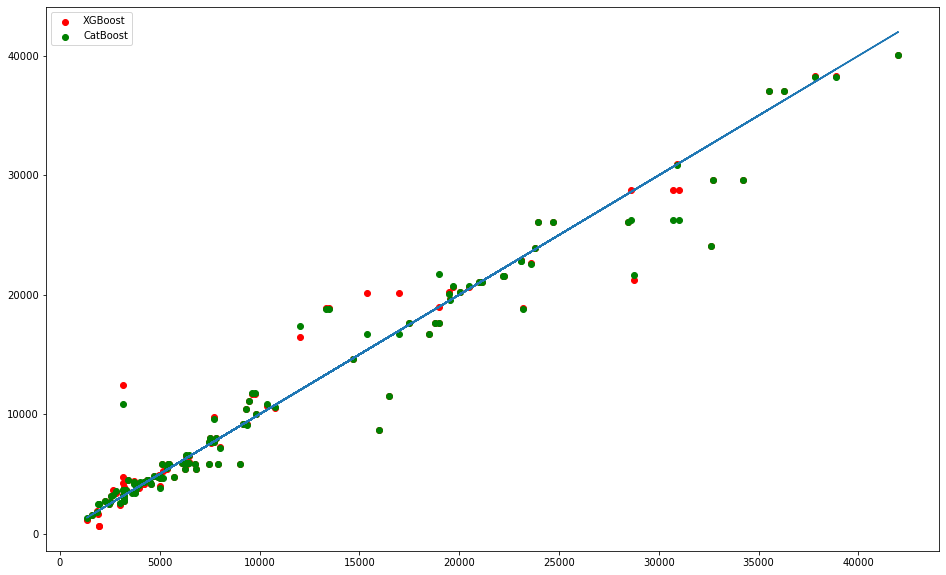

In [110]:
##  Visualize the predictions made by 2 different models. 
## CatBoostRegressor looks to be slightly better than XGBoostRegressor

plt.figure(figsize=(16,10))
plt.plot(y_test,y_test)
plt.scatter(y_test,y_pred1,color='r', label = 'XGBoost')
plt.scatter(y_test,y_pred2,color='g',label='CatBoost')
plt.legend()
plt.show()

In [111]:
pairs = {}               ## create a dictionary to convert the input brand names into the numerical values in the training. 
for k,v in zip(df1.Brand.unique(),np.arange(9)):
    pairs[k]=v
pairs

{'Apple': 0,
 'General Mobile': 1,
 'Huawei': 2,
 'Oppo': 3,
 'POCO': 4,
 'realme': 5,
 'Reeder': 6,
 'Samsung': 7,
 'TCL': 8}

**In the cell below, the code requires you to enter the desired features of a smartphone and predicts price for those product features.**

In [112]:
Brand = input('Brand :').lower().title().strip()
Brand = pairs[Brand]
if Brand =='apple':
    OS = 1
else:
    OS = 0
    
Cpu = input('Cpu:')
RAM = input('RAM:')
Storage= input('Storage:')
Cam= input('Camera Resolution:')
Scr= input('Screen Size:')


feat=np.array([Brand,Cpu,RAM,Storage,OS,Cam,Scr])
pricex = model2.predict(feat)                            ## input cell for user to define desired features. The model makes prediction

print(f'The Price of the product : {pricex}')

Brand :Apple
Cpu:2.8
RAM:8
Storage:32
Camera Resolution:20
Screen Size:6.25
The Price of the product : 9948.8330609456
